# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
import time, psutil
device = torch.device('cpu')

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
        
        array = array.reshape(1, self.height,self.width)
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
color_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.4),
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(brightness=0.6),
        transforms.ColorJitter(brightness=0.7)
    ]),
    transforms.ToTensor()
])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=color_transformations)
print(dataset)

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.8)
whole_test_size = datasetsize - train_size
single_part_size = int(whole_test_size/3) #whole test data is divided into 3 parts - for test, do1 and do2

# if datasetsize != (train_size + single_part_size*3):
#     train_size += 1

print(f"Whole dataset size: {datasetsize}\n"
      f"Train dataset size: {train_size}\n"
      f"Whole train size: {whole_test_size}\n"
      f"Test, DO1 and DO2 sizes: {single_part_size}")

Whole dataset size: 1265
Train dataset size: 1012
Whole train size: 253
Test, DO1 and DO2 sizes: 84


1012, 253


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


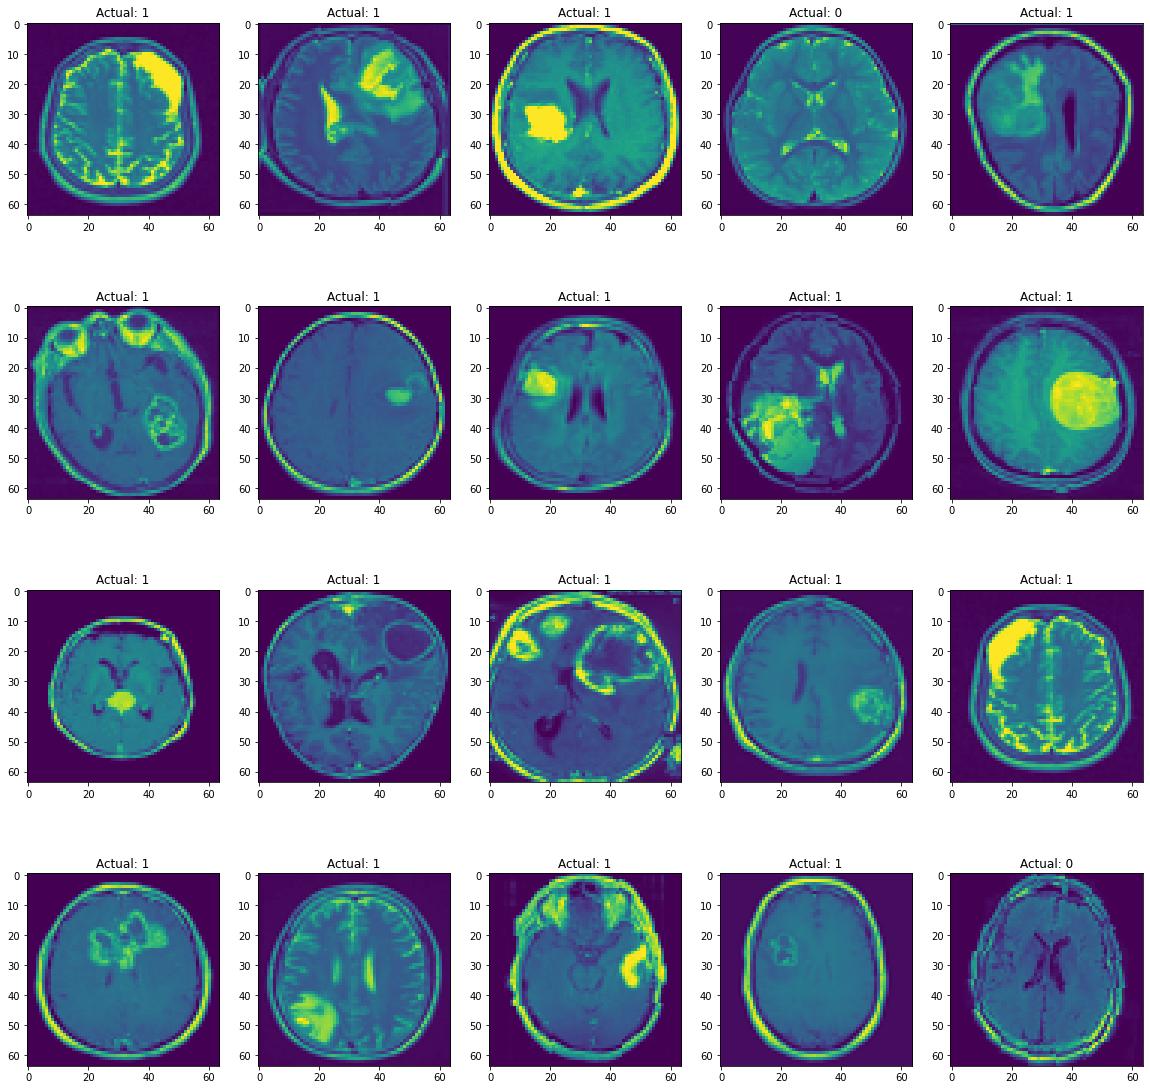

In [6]:
# train_data, test_data, do1_data, do2_data = torch.utils.data.random_split(dataset, [train_size, single_part_size, single_part_size, single_part_size])

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, whole_test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [7]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        # print(x.shape)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)
        # print(x.shape)

        return x

In [8]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [9]:
#dict example
# {
#     "model": BrainTumorModel(torch_ref=torch),
#     "learning_rate": 0.0001
#     "epochs": 100
# }
models_and_params = []

for i in range(1, 11):
    models_and_params.append({
        "model": BrainTumorModel(torch_ref=torch),
        "learning_rate": 0.0001,
        "epochs": 100*(i*2)
    })

print(models_and_params)



[{'model': <__main__.BrainTumorModel object at 0x7f2e991a83d0>, 'learning_rate': 0.0001, 'epochs': 200}, {'model': <__main__.BrainTumorModel object at 0x7f2f5c187220>, 'learning_rate': 0.0001, 'epochs': 400}, {'model': <__main__.BrainTumorModel object at 0x7f2e991a8340>, 'learning_rate': 0.0001, 'epochs': 600}, {'model': <__main__.BrainTumorModel object at 0x7f2e991a84f0>, 'learning_rate': 0.0001, 'epochs': 800}, {'model': <__main__.BrainTumorModel object at 0x7f2e991a8040>, 'learning_rate': 0.0001, 'epochs': 1000}, {'model': <__main__.BrainTumorModel object at 0x7f2e9919daf0>, 'learning_rate': 0.0001, 'epochs': 1200}, {'model': <__main__.BrainTumorModel object at 0x7f2e9919df70>, 'learning_rate': 0.0001, 'epochs': 1400}, {'model': <__main__.BrainTumorModel object at 0x7f2e9919d610>, 'learning_rate': 0.0001, 'epochs': 1600}, {'model': <__main__.BrainTumorModel object at 0x7f2e9919d5e0>, 'learning_rate': 0.0001, 'epochs': 1800}, {'model': <__main__.BrainTumorModel object at 0x7f2e9919d4

In [10]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# num_epochs = 800

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, optimizer, num_epochs = 100, batch_size = 32,):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            model.eval()
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
            model.train()
        loss_list.append(total_loss/batch_size)
    return loss_list

In [20]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# loss_list_dumb = train(model, train_data, test_data,optimizer, num_epochs=1800)
# loss_list = [loss_item.detach() for loss_item in loss_list_dumb]


for idx, model_and_params in enumerate(models_and_params):
    # get attributes
    model = model_and_params["model"] 
    epochs = model_and_params["epochs"]
    optimizer = optim.Adam(model.parameters(), lr=model_and_params["learning_rate"])
    print(f"---------------------------------------")
    print(f"Started model {idx} for {epochs} epochs")
    start_time = time.time()
    # train model
    loss_list_dumb = train(model, train_data, test_data,optimizer, num_epochs=epochs)
    model_and_params["loss_list"] = [loss_item.detach() for loss_item in loss_list_dumb]
    
    
    print(f"Finished model {idx} for {epochs} epochs, for {time.time() - start_time}")
    print(f"---------------------------------------")
    
    

---------------------------------------
Started model 0 for 200 epochs


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  1.2795, Accuracy:  0.5729
Epochs: 10 Loss:  1.0802, Accuracy:  0.6237
Epochs: 20 Loss:  0.7300, Accuracy:  0.6045
Epochs: 30 Loss:  0.6087, Accuracy:  0.6045
Epochs: 40 Loss:  0.6280, Accuracy:  0.6045
Epochs: 50 Loss:  0.5297, Accuracy:  0.6280
Epochs: 60 Loss:  0.5236, Accuracy:  0.6162
Epochs: 70 Loss:  0.6228, Accuracy:  0.6319
Epochs: 80 Loss:  0.5051, Accuracy:  0.6202
Epochs: 90 Loss:  0.5904, Accuracy:  0.6162
Epochs: 100 Loss:  0.6140, Accuracy:  0.6006
Epochs: 110 Loss:  0.5728, Accuracy:  0.6202
Epochs: 120 Loss:  0.4644, Accuracy:  0.6241
Epochs: 130 Loss:  0.5547, Accuracy:  0.6202
Epochs: 140 Loss:  0.4597, Accuracy:  0.6870
Epochs: 150 Loss:  0.4535, Accuracy:  0.7229
Epochs: 160 Loss:  0.4878, Accuracy:  0.6791
Epochs: 170 Loss:  0.5769, Accuracy:  0.7225
Epochs: 180 Loss:  0.4176, Accuracy:  0.6905
Epochs: 190 Loss:  0.3860, Accuracy:  0.6835
Finished model 0 for 200 epochs, for 78.64700245857239
---------------------------------------
----------------

Epochs: 520 Loss:  0.3542, Accuracy:  0.6983
Epochs: 530 Loss:  0.3662, Accuracy:  0.7221
Epochs: 540 Loss:  0.4027, Accuracy:  0.7061
Epochs: 550 Loss:  0.3288, Accuracy:  0.7260
Epochs: 560 Loss:  0.3143, Accuracy:  0.7178
Epochs: 570 Loss:  0.1988, Accuracy:  0.7139
Epochs: 580 Loss:  0.3666, Accuracy:  0.7147
Epochs: 590 Loss:  0.3311, Accuracy:  0.7182
Epochs: 600 Loss:  0.4463, Accuracy:  0.7022
Epochs: 610 Loss:  0.5047, Accuracy:  0.7182
Epochs: 620 Loss:  0.1956, Accuracy:  0.7217
Epochs: 630 Loss:  0.3217, Accuracy:  0.7143
Epochs: 640 Loss:  0.4131, Accuracy:  0.7225
Epochs: 650 Loss:  0.3712, Accuracy:  0.7303
Epochs: 660 Loss:  0.3425, Accuracy:  0.7143
Epochs: 670 Loss:  0.5009, Accuracy:  0.7299
Epochs: 680 Loss:  0.2395, Accuracy:  0.7221
Epochs: 690 Loss:  0.4633, Accuracy:  0.7260
Epochs: 700 Loss:  0.3962, Accuracy:  0.7377
Epochs: 710 Loss:  0.4294, Accuracy:  0.7256
Epochs: 720 Loss:  0.5357, Accuracy:  0.7264
Epochs: 730 Loss:  0.4457, Accuracy:  0.7303
Epochs: 74

Epochs: 480 Loss:  0.3823, Accuracy:  0.7061
Epochs: 490 Loss:  0.5000, Accuracy:  0.7299
Epochs: 500 Loss:  0.2813, Accuracy:  0.7221
Epochs: 510 Loss:  0.3078, Accuracy:  0.7186
Epochs: 520 Loss:  0.3439, Accuracy:  0.7307
Epochs: 530 Loss:  0.3768, Accuracy:  0.7178
Epochs: 540 Loss:  0.3651, Accuracy:  0.7178
Epochs: 550 Loss:  0.5953, Accuracy:  0.7217
Epochs: 560 Loss:  0.4283, Accuracy:  0.7569
Epochs: 570 Loss:  0.3870, Accuracy:  0.7221
Epochs: 580 Loss:  0.4137, Accuracy:  0.7174
Epochs: 590 Loss:  0.2285, Accuracy:  0.7182
Epochs: 600 Loss:  0.4019, Accuracy:  0.7342
Epochs: 610 Loss:  0.3603, Accuracy:  0.7260
Epochs: 620 Loss:  0.3565, Accuracy:  0.7100
Epochs: 630 Loss:  0.3338, Accuracy:  0.7178
Epochs: 640 Loss:  0.2979, Accuracy:  0.7295
Epochs: 650 Loss:  0.6087, Accuracy:  0.7182
Epochs: 660 Loss:  0.4655, Accuracy:  0.7061
Epochs: 670 Loss:  0.4454, Accuracy:  0.7182
Epochs: 680 Loss:  0.3667, Accuracy:  0.7377
Epochs: 690 Loss:  0.4138, Accuracy:  0.7377
Epochs: 70

Epochs: 1060 Loss:  0.2756, Accuracy:  0.7268
Epochs: 1070 Loss:  0.4036, Accuracy:  0.7272
Epochs: 1080 Loss:  0.3753, Accuracy:  0.7511
Epochs: 1090 Loss:  0.4342, Accuracy:  0.7589
Epochs: 1100 Loss:  0.1844, Accuracy:  0.7589
Epochs: 1110 Loss:  0.3406, Accuracy:  0.7858
Epochs: 1120 Loss:  0.3171, Accuracy:  0.7706
Epochs: 1130 Loss:  0.3237, Accuracy:  0.7194
Epochs: 1140 Loss:  0.3303, Accuracy:  0.7507
Epochs: 1150 Loss:  0.3158, Accuracy:  0.7350
Epochs: 1160 Loss:  0.3267, Accuracy:  0.7706
Epochs: 1170 Loss:  0.2718, Accuracy:  0.7429
Epochs: 1180 Loss:  0.2519, Accuracy:  0.7624
Epochs: 1190 Loss:  0.1654, Accuracy:  0.7628
Epochs: 1200 Loss:  0.2477, Accuracy:  0.7745
Epochs: 1210 Loss:  0.3077, Accuracy:  0.7667
Epochs: 1220 Loss:  0.4502, Accuracy:  0.7702
Epochs: 1230 Loss:  0.2772, Accuracy:  0.7546
Epochs: 1240 Loss:  0.2192, Accuracy:  0.7507
Epochs: 1250 Loss:  0.2894, Accuracy:  0.7593
Epochs: 1260 Loss:  0.3271, Accuracy:  0.7702
Epochs: 1270 Loss:  0.2758, Accura

Epochs: 1430 Loss:  0.2408, Accuracy:  0.7980
Epochs: 1440 Loss:  0.3298, Accuracy:  0.7858
Epochs: 1450 Loss:  0.2171, Accuracy:  0.7698
Epochs: 1460 Loss:  0.2805, Accuracy:  0.7897
Epochs: 1470 Loss:  0.2241, Accuracy:  0.7819
Epochs: 1480 Loss:  0.2978, Accuracy:  0.7819
Epochs: 1490 Loss:  0.2953, Accuracy:  0.7698
Epochs: 1500 Loss:  0.1662, Accuracy:  0.8015
Epochs: 1510 Loss:  0.4100, Accuracy:  0.7698
Epochs: 1520 Loss:  0.2331, Accuracy:  0.7819
Epochs: 1530 Loss:  0.4507, Accuracy:  0.8253
Epochs: 1540 Loss:  0.1729, Accuracy:  0.8253
Epochs: 1550 Loss:  0.2292, Accuracy:  0.7940
Epochs: 1560 Loss:  0.2897, Accuracy:  0.7936
Epochs: 1570 Loss:  0.3294, Accuracy:  0.8093
Epochs: 1580 Loss:  0.1315, Accuracy:  0.8374
Epochs: 1590 Loss:  0.1560, Accuracy:  0.8097
Finished model 7 for 1600 epochs, for 592.98907995224
---------------------------------------
---------------------------------------
Started model 8 for 1800 epochs
Epochs: 0 Loss:  0.8240, Accuracy:  0.5651
Epochs: 1

Epochs: 1600 Loss:  0.1428, Accuracy:  0.8097
Epochs: 1610 Loss:  0.2406, Accuracy:  0.8019
Epochs: 1620 Loss:  0.2583, Accuracy:  0.8097
Epochs: 1630 Loss:  0.2314, Accuracy:  0.8171
Epochs: 1640 Loss:  0.2523, Accuracy:  0.8214
Epochs: 1650 Loss:  0.2650, Accuracy:  0.8132
Epochs: 1660 Loss:  0.1392, Accuracy:  0.8058
Epochs: 1670 Loss:  0.2708, Accuracy:  0.8413
Epochs: 1680 Loss:  0.1226, Accuracy:  0.8257
Epochs: 1690 Loss:  0.1666, Accuracy:  0.8292
Epochs: 1700 Loss:  0.2827, Accuracy:  0.8214
Epochs: 1710 Loss:  0.2480, Accuracy:  0.8296
Epochs: 1720 Loss:  0.2960, Accuracy:  0.7901
Epochs: 1730 Loss:  0.0862, Accuracy:  0.8335
Epochs: 1740 Loss:  0.2065, Accuracy:  0.8175
Epochs: 1750 Loss:  0.1842, Accuracy:  0.8296
Epochs: 1760 Loss:  0.1662, Accuracy:  0.8218
Epochs: 1770 Loss:  0.2758, Accuracy:  0.8171
Epochs: 1780 Loss:  0.2662, Accuracy:  0.8448
Epochs: 1790 Loss:  0.1067, Accuracy:  0.8140
Finished model 8 for 1800 epochs, for 672.6146724224091
------------------------

Epochs: 1570 Loss:  0.3039, Accuracy:  0.8218
Epochs: 1580 Loss:  0.2600, Accuracy:  0.7984
Epochs: 1590 Loss:  0.2119, Accuracy:  0.8015
Epochs: 1600 Loss:  0.2293, Accuracy:  0.8058
Epochs: 1610 Loss:  0.3242, Accuracy:  0.7741
Epochs: 1620 Loss:  0.3180, Accuracy:  0.8179
Epochs: 1630 Loss:  0.1511, Accuracy:  0.8062
Epochs: 1640 Loss:  0.1908, Accuracy:  0.8101
Epochs: 1650 Loss:  0.2057, Accuracy:  0.8062
Epochs: 1660 Loss:  0.2564, Accuracy:  0.8019
Epochs: 1670 Loss:  0.2003, Accuracy:  0.8058
Epochs: 1680 Loss:  0.1719, Accuracy:  0.8140
Epochs: 1690 Loss:  0.3424, Accuracy:  0.8105
Epochs: 1700 Loss:  0.2721, Accuracy:  0.8296
Epochs: 1710 Loss:  0.3029, Accuracy:  0.8296
Epochs: 1720 Loss:  0.2551, Accuracy:  0.8339
Epochs: 1730 Loss:  0.2367, Accuracy:  0.8378
Epochs: 1740 Loss:  0.3562, Accuracy:  0.8222
Epochs: 1750 Loss:  0.1236, Accuracy:  0.8300
Epochs: 1760 Loss:  0.1875, Accuracy:  0.8132
Epochs: 1770 Loss:  0.1430, Accuracy:  0.8140
Epochs: 1780 Loss:  0.1472, Accura

### Models evaluation + Loss Plot

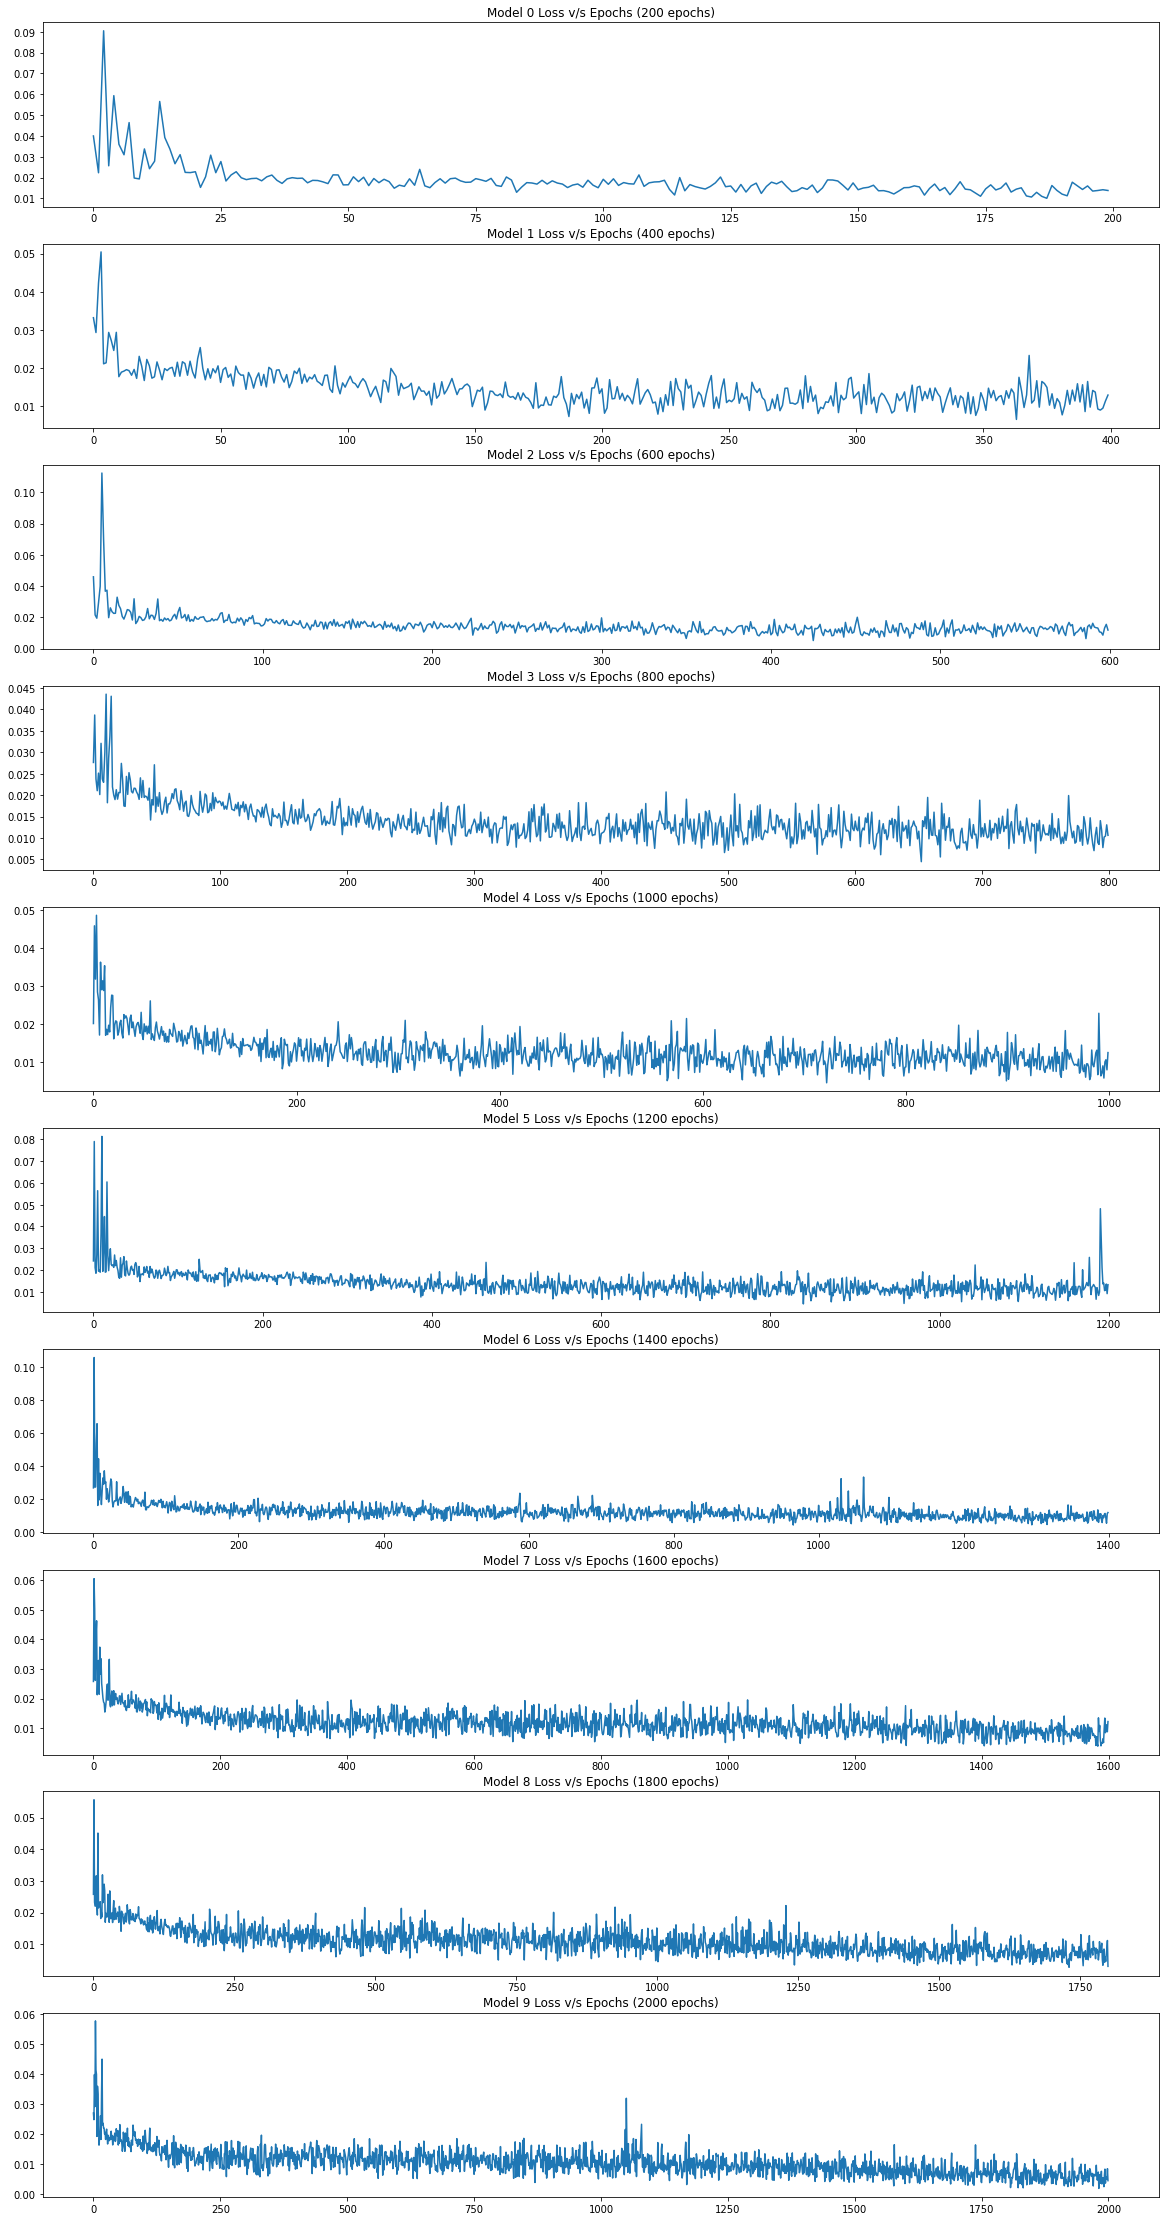

In [21]:

# fig = plt.figure(figsize=(20,20))
fig, axs = plt.subplots(10, figsize=(20,40))

for x in range(0,10):
    # 1st column
    first_model_and_params = models_and_params[x]
    axs[x].plot(list(range(first_model_and_params["epochs"])), first_model_and_params["loss_list"])
    axs[x].set_title(f"Model {x} Loss v/s Epochs ({first_model_and_params['epochs']} epochs)")
    

# plt.figure
# plt.show()
# num_epochs = 1800
# plot = True
# if plot:
#     fig = plt.figure(figsize=(20,10))
#     plt.plot(list(range(num_epochs)),loss_list)
#     plt.title("Loss v/s Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.show()

In [22]:
#evaluate single model
# model.eval()
# test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
# test_loss, accuracy, = test(model, test_loader, loss_fn)
# print(f'Test Accuracy: {accuracy:.4f} |'
#       f'Test Loss: {test_loss:.4f}\n')

# #Evaluate trained models
for idx, model_and_params in enumerate(models_and_params):
    print(f"Evaluating model {idx}")
    model = model_and_params["model"]
    model.eval()
    
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    test_loss, accuracy, = test(model, test_loader, loss_fn)
    print(f'Test Accuracy: {accuracy:.4f} |'
          f'Test Loss: {test_loss:.4f}\n')


Evaluating model 0


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.7036 |Test Loss: 0.5844

Evaluating model 1
Test Accuracy: 0.7075 |Test Loss: 0.7088

Evaluating model 2
Test Accuracy: 0.7233 |Test Loss: 0.6612

Evaluating model 3
Test Accuracy: 0.7194 |Test Loss: 0.8425

Evaluating model 4
Test Accuracy: 0.7628 |Test Loss: 0.7773

Evaluating model 5
Test Accuracy: 0.7470 |Test Loss: 0.7743

Evaluating model 6
Test Accuracy: 0.7826 |Test Loss: 0.7675

Evaluating model 7
Test Accuracy: 0.8142 |Test Loss: 0.8085

Evaluating model 8
Test Accuracy: 0.8261 |Test Loss: 0.9280

Evaluating model 9
Test Accuracy: 0.8340 |Test Loss: 1.1557



In [23]:
# chosing the 8th model as the main one
model = models_and_params[0]["model"]

<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


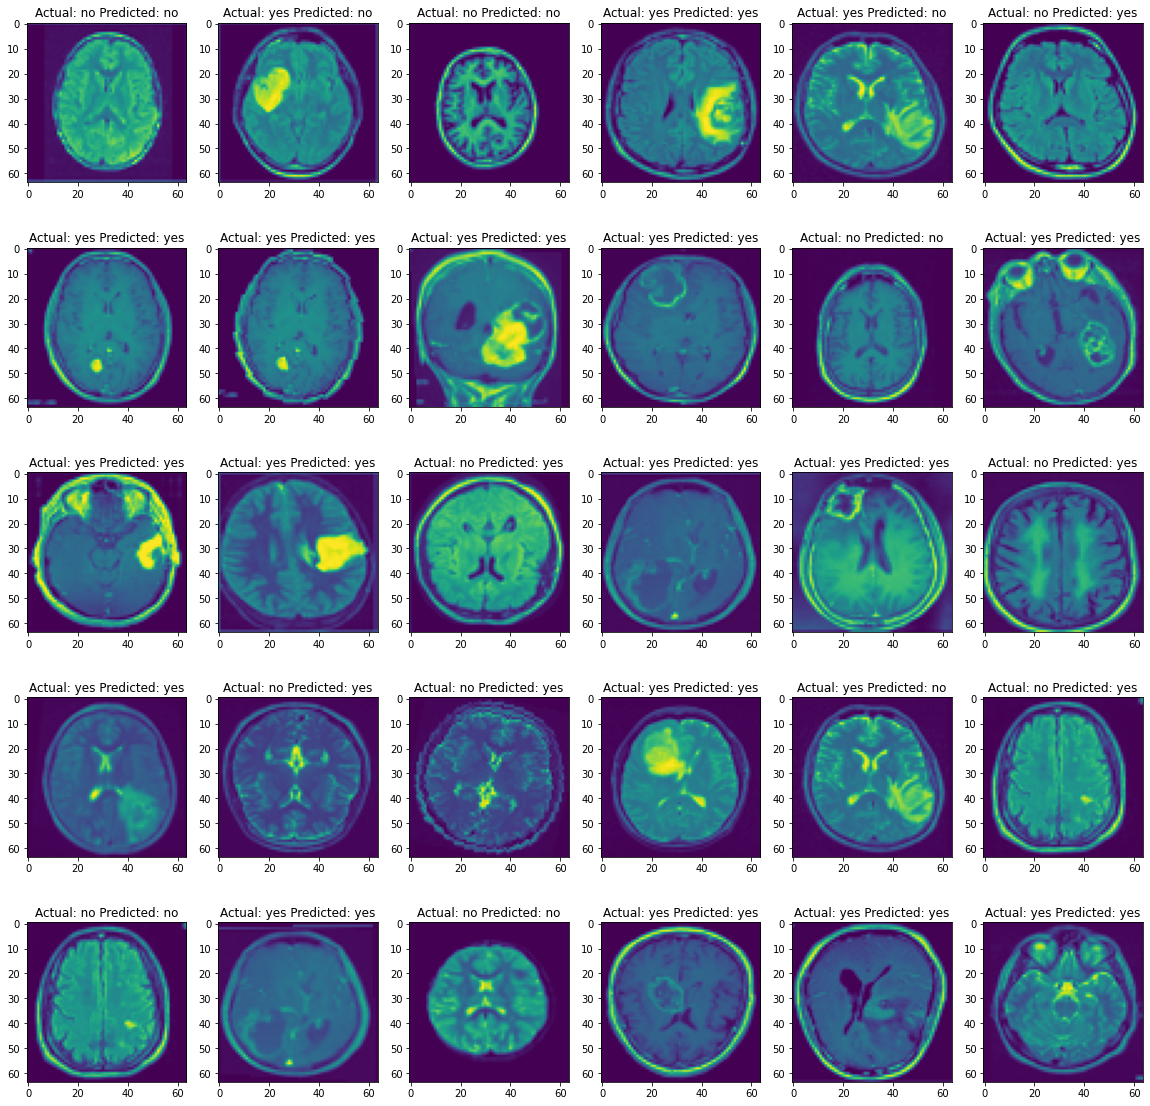

actual accuracy:  0.70


In [24]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
raw_weights = []
for img, lbl in plot_loader:
    if i == 30: break
    pred = model(img.float())
    raw_weights.append(pred)
#     print(pred)
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(5,6,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [36]:
raw_weights_v2list = []
for img, lbl in plot_loader:
    raw_weights = model(img.float())
    raw_weights_v2list.append(raw_weights)

<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


In [37]:
raw_weights_v2list

[tensor([[ 0.4862, -0.3898]], grad_fn=<AddmmBackward>),
 tensor([[ 2.7723, -0.5546]], grad_fn=<AddmmBackward>),
 tensor([[ 0.4224, -0.3117]], grad_fn=<AddmmBackward>),
 tensor([[-0.2078,  0.3149]], grad_fn=<AddmmBackward>),
 tensor([[0.0450, 0.0654]], grad_fn=<AddmmBackward>),
 tensor([[-0.2970,  0.4014]], grad_fn=<AddmmBackward>),
 tensor([[-0.4724,  0.9917]], grad_fn=<AddmmBackward>),
 tensor([[-0.0042,  0.1048]], grad_fn=<AddmmBackward>),
 tensor([[-0.6710,  0.7817]], grad_fn=<AddmmBackward>),
 tensor([[-2.0731,  3.0955]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1571, -0.0508]], grad_fn=<AddmmBackward>),
 tensor([[-0.0582,  0.1656]], grad_fn=<AddmmBackward>),
 tensor([[-0.6738,  0.7975]], grad_fn=<AddmmBackward>),
 tensor([[-0.5512,  0.6466]], grad_fn=<AddmmBackward>),
 tensor([[-0.6403,  0.7498]], grad_fn=<AddmmBackward>),
 tensor([[ 0.2048, -0.1079]], grad_fn=<AddmmBackward>),
 tensor([[-0.7342,  0.8406]], grad_fn=<AddmmBackward>),
 tensor([[-0.4800,  0.5779]], grad_fn=<AddmmBackwa

In [28]:
for row_pred, raw_weight in list(zip(raw_predictions,raw_weights)):
    print(f"row_pred: {row_pred} | raw_weight: {raw_weight}")


row_pred: tensor([0]) | raw_weight: tensor([[ 0.3204, -0.2188]], grad_fn=<AddmmBackward>)
row_pred: tensor([0]) | raw_weight: tensor([[ 2.7723, -0.5546]], grad_fn=<AddmmBackward>)
row_pred: tensor([0]) | raw_weight: tensor([[ 0.4689, -0.3664]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-0.4316,  0.5407]], grad_fn=<AddmmBackward>)
row_pred: tensor([0]) | raw_weight: tensor([[0.0842, 0.0249]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-0.5572,  0.6668]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-0.4724,  0.9917]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-0.0187,  0.1315]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-0.5966,  0.7185]], grad_fn=<AddmmBackward>)
row_pred: tensor([1]) | raw_weight: tensor([[-2.0731,  3.0955]], grad_fn=<AddmmBackward>)
row_pred: tensor([0]) | raw_weight: tensor([[ 0.1974, -0.0888]], grad_fn=<AddmmBackward>)
row_pred: te

### SyMPC part


In [29]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [30]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [31]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)



In [32]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
#     if i == 20: break
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(ptrs)



<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


253

In [33]:
mpc_model = model.share(session)
mpc_model

In [ ]:
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

In [34]:
#Perform inference and measure time taken
start_time = time.time()
cpu_usage = []
memory_usage = []
results = []

for idx,ptr in enumerate(ptrs):
    if i == 50: break
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    cpu_usage.append(psutil.cpu_percent())
    memory_usage.append(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2022-04-26T08:50:43.963401+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8796c5440f34a6281b7b331d8af8ccc>.
[2022-04-26T08:50:43.970159+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df579640848c4f79a46cd13765c0aebe>.
[2022-04-26T08:51:47.607589+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11318198a1b54c4c8fd0e8c4eef5005e>.
[2022-04-26T08:51:47.614862+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41fd117774a640b4bff3bb8c6e1ae764>.
[2022-04-26T08:52:19.509254+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb7459b084cb4747b25002e16c0849dc>.
[2022-04-26T08:52:19.511874+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd864ec5912548a9b23b6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.1090, -0.9910]])


[2022-04-26T08:52:29.059971+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88fa2849144a4dd3b913f33150936e59>.
[2022-04-26T08:52:29.066134+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90930243840f4bda8ffced122f8eb482>.
[2022-04-26T08:52:29.073876+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 677557cd5bfb45a780cf357fccf20202>.
[2022-04-26T08:52:29.079385+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4105dd7236ec4dc29986b03a6d376e38>.
[2022-04-26T08:53:31.490570+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c6a31bcedad4da09ef84213783f0d55>.
[2022-04-26T08:53:31.497514+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be2c34a5cbc04571b0614

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[2.5463, 0.9423]])


[2022-04-26T08:54:12.724847+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bad9450d54664758820665506586eeb9>.
[2022-04-26T08:54:12.731871+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07f5f016c7044e3f92ddfa638d1f3085>.
[2022-04-26T08:55:14.551575+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2073a41e13f34aefb7d3042e1dbc9c0f>.
[2022-04-26T08:55:14.559524+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8349a998ff17465f83b7a079db9ebd32>.
[2022-04-26T08:55:45.956751+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a38dc13462b84f93aeadfa8c2e736663>.
[2022-04-26T08:55:45.959574+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9a3ca6e38d445029d44e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.9268, -2.7997]])


[2022-04-26T08:55:55.497971+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5246dee0640c41a0b631452395bc8773>.
[2022-04-26T08:55:55.505101+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a704e388919c40729150eb57f330d043>.
[2022-04-26T08:55:55.522631+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c95f0ef6b234017a23386adf486c560>.
[2022-04-26T08:55:55.525511+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 631e03f278064bfbb7f65051792a6b7e>.
[2022-04-26T08:55:55.534386+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82a3fedcfe0640af9c188b9dc96cf72c>.
[2022-04-26T08:55:55.537120+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: def8f20b51444bf4bcd2a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5950,  0.7569]])


[2022-04-26T08:57:39.032588+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6318c6f326849be8e1d3e96621167d9>.
[2022-04-26T08:57:39.039518+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4f777f150f8457e9006ed10ad8d0e31>.
[2022-04-26T08:57:39.051900+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02bb2f569e114fc8a5fef34a7d1804ae>.
[2022-04-26T08:57:39.056866+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 512a63b090d6435284b4c66dec7c6ef5>.
[2022-04-26T08:57:39.065644+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57bc56a17b3c4885abb9106c8cb2f21e>.
[2022-04-26T08:57:39.068333+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f04c7707b2124f36b8406

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2789,  0.3954]])


[2022-04-26T08:59:22.374722+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91d69d53400d449f81d93605ea119015>.
[2022-04-26T08:59:22.381471+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28a577f898c045349fef7071370df6a6>.
[2022-04-26T08:59:22.398485+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5fef0bafec242abb9b38e66e1cc5133>.
[2022-04-26T08:59:22.401039+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7509d84af2f4f86badd62003ad21d44>.
[2022-04-26T08:59:22.405164+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6c4cccbefa64e2983ddcc75215bfba9>.
[2022-04-26T08:59:22.407538+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b52aef08d214004a0837

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1884,  0.3173]])


[2022-04-26T09:01:05.895874+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ab836b9947a4a4896dafd2f5c28d5cf>.
[2022-04-26T09:01:05.903330+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ef3dd379b4744ec928a40aff33d1a01>.
[2022-04-26T09:01:05.922745+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ddf01960feca4d958534ffd6a23ef744>.
[2022-04-26T09:01:05.925786+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b31a741eb324b60ad8212496765121c>.
[2022-04-26T09:01:05.930355+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d9ab46dc61494155aea438ba21a0a06f>.
[2022-04-26T09:01:05.932959+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04e35009986246c3b5048

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9511,  1.1806]])


[2022-04-26T09:02:49.675920+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4c37017edcb4c3aa0a59f280de23b3f>.
[2022-04-26T09:02:49.682946+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f3163e9b97e64a76b5a803e84c6ea993>.
[2022-04-26T09:02:49.941277+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: daeaab5216a04d3aadf4c91ae89a35b3>.
[2022-04-26T09:02:49.946931+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 238c5dd33f0c4835a25e2d8c1818f93c>.
[2022-04-26T09:03:52.035990+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 708e736e983f4dae86163ff9c0a09c2b>.
[2022-04-26T09:03:52.043014+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ed03dbfb4b54b6794dbe

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0236, 0.1086]])


[2022-04-26T09:04:30.523897+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a3ce03664ba4bed8e9ef2b827e38ecb>.
[2022-04-26T09:04:30.527658+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47ae077bfb9c4d13878019d110294fe2>.
[2022-04-26T09:04:30.533088+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44fce9c35fed4a31b8e879af8ba413fe>.
[2022-04-26T09:04:30.535485+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 201aa5f988a943b186bb8c4ca73607ee>.
[2022-04-26T09:04:30.543996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f86f86ea0bb6416b8bd84592d57f1743>.
[2022-04-26T09:04:30.546604+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ceaea84743dc4f8da9013

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6267,  0.7480]])


[2022-04-26T09:06:15.290690+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 428779e6078141f8b3ccf2947f962a64>.
[2022-04-26T09:06:15.298108+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9e17f383d79474cba9b4438d6e38d69>.
[2022-04-26T09:06:15.314828+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1244bbd1540a423aa3601b4c51db7f24>.
[2022-04-26T09:06:15.317698+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74faad274e64470e87db35067397b3d0>.
[2022-04-26T09:06:15.326697+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85744098daad4aebb1b7e84ecd6c5101>.
[2022-04-26T09:06:15.329288+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32a3696517fa4da18d017

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3320,  3.3248]])


[2022-04-26T09:07:58.564026+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 335dfc7551e24065b825e5823dd2e8ae>.
[2022-04-26T09:07:58.571967+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 463b5150a4e0457cacea1f7333bb5029>.
[2022-04-26T09:07:58.588227+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06448a92d3e54756bb9f75ae182d372a>.
[2022-04-26T09:07:58.595061+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2017a5a986644c9193f1e1c362cf79d5>.
[2022-04-26T09:07:58.604258+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3aa9db0c23b64ca1bff6573375aa4f61>.
[2022-04-26T09:07:58.606791+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9eac6320a2c44f6daca79

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.6842, -0.5676]])


[2022-04-26T09:09:41.197082+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb8e82d3c05846a096a71bf5b72db007>.
[2022-04-26T09:09:41.204304+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4013e02f098d40acbb0df153b9db08c0>.
[2022-04-26T09:09:41.222021+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa4dd049ada242268508ce104abe9142>.
[2022-04-26T09:09:41.224900+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47a2f05c0316475c9bbc7465cabb5e02>.
[2022-04-26T09:09:41.233509+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc4f36cf1f864a58bf6e7c66fc2ff17d>.
[2022-04-26T09:09:41.235907+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68748669049b4ee1af28a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0634, 0.0428]])


[2022-04-26T09:11:24.225905+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a20c73eecf5842d08eeec70e84954f4f>.
[2022-04-26T09:11:24.233043+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4ffd0d94fbc41c38e824f66852803ca>.
[2022-04-26T09:11:24.250720+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d2d0b62810746369ca25086f2684f34>.
[2022-04-26T09:11:24.254137+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 425e0565b7ac4910ab63e14d6b47b81c>.
[2022-04-26T09:11:24.258766+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01893a78c8414e41b7e83359a2f25eb6>.
[2022-04-26T09:11:24.261794+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbd03e053a3a402c86602

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4682,  0.6087]])


[2022-04-26T09:13:06.679382+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c31dab8e7ff14fa489bff66ab88c8141>.
[2022-04-26T09:13:06.686577+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75513380357d4b8f8b9d92494d711e65>.
[2022-04-26T09:13:06.706734+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 921b528c63664320838c3ac449b27828>.
[2022-04-26T09:13:06.709400+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3a2dc4e956e46fa9113828df635c3cb>.
[2022-04-26T09:13:06.713416+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc534b933538437b89f8481f24dc965e>.
[2022-04-26T09:13:06.715893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb693ae01ba3484296376

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5513,  0.6454]])


[2022-04-26T09:14:49.180015+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8eefef57d541437f906cc481d225c361>.
[2022-04-26T09:14:49.187178+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e980422fe2b546dbb0aaaf71cabe9ab6>.
[2022-04-26T09:14:49.206870+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a63f43e73fdd4ef4a0a0e0683e525b31>.
[2022-04-26T09:14:49.210456+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11f595453c54464ab1a5e6e1cb91710b>.
[2022-04-26T09:14:49.215693+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3accc6e95b8241d8a3a91a395d815da2>.
[2022-04-26T09:14:49.218834+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e633f0d690340df8835f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6991,  0.8538]])


[2022-04-26T09:16:32.330772+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf01973d04524572b46347f47fdcc13f>.
[2022-04-26T09:16:32.337387+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad0e8bba52a34788b8cb4bf647bec31e>.
[2022-04-26T09:16:32.345688+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c141365ba1c643ae85ac75040916900b>.
[2022-04-26T09:16:32.350243+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a31b83da8af4e22995a843e67383553>.
[2022-04-26T09:16:32.567020+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c4a6fbc859f45c48bc549c4c3a8ad8c>.
[2022-04-26T09:16:32.569865+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8d15d9679b445c19b9b3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4336,  0.5414]])


[2022-04-26T09:18:15.500804+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e921c8e1564444c9768154a2be90605>.
[2022-04-26T09:18:15.508539+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc28f06b3e34e759d5d177b884fdce2>.
[2022-04-26T09:18:15.522026+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ee7411e64ce441783a38da7e65b280e>.
[2022-04-26T09:18:15.527814+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90add789ffb140209fcf72145c945435>.
[2022-04-26T09:18:15.537096+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 672506577e77479b93510b9ce140e8bd>.
[2022-04-26T09:18:15.539843+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87d60e7fa37b46cb84d57

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7010,  0.8085]])


[2022-04-26T09:19:59.154138+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68f163c26a2e4e92b4d94b6ab689362f>.
[2022-04-26T09:19:59.162427+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 432bd04978fe4c49b9c95e27a175c986>.
[2022-04-26T09:19:59.175281+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d5455f104124cf593318dae3ab70c49>.
[2022-04-26T09:19:59.180690+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7086277a4cab4b338f14c0ffb3965480>.
[2022-04-26T09:19:59.189309+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73ed1bb5498b4c18b1e425ff61fadb6a>.
[2022-04-26T09:19:59.191741+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7765702439ec46f2a73f2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5012,  0.6024]])


[2022-04-26T09:21:43.454194+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 684315ee9e484a96bf100fec8c24f1ff>.
[2022-04-26T09:21:43.461192+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82b9130c17354be8830c7734b5bf442f>.
[2022-04-26T09:21:43.478700+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 377292e5c49c40eeaec9338fcf97d2ff>.
[2022-04-26T09:21:43.481494+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04a9c1f1f9a143a29c0cec59cdecb131>.
[2022-04-26T09:21:43.490244+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76adcb0f7f2e42ca83c74ae3a3837429>.
[2022-04-26T09:21:43.492929+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac73773bb53241a1a3d2a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1821,  0.3147]])


[2022-04-26T09:23:27.079895+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 849749e141764434b01082f8dce5c4ed>.
[2022-04-26T09:23:27.087901+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 86f3eec695a8448c8edc506bf90a2a67>.
[2022-04-26T09:23:27.107819+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ea14b44a6914b9bbdff447d36630fcb>.
[2022-04-26T09:23:27.110686+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70bf3508ea8e4b7abff3c7770ebf2b54>.
[2022-04-26T09:23:27.114896+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c79de5f627c24c24afa5933199f8746e>.
[2022-04-26T09:23:27.117661+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14254a43b8d94ef197395

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0817,  0.1937]])


[2022-04-26T09:25:09.974727+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 898c366fd50f431d8b40c6b838478a87>.
[2022-04-26T09:25:09.982512+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91bc48e7372f43169b3523dace26891b>.
[2022-04-26T09:25:09.996529+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90bb836721e04fd5aaad2ec3f5ed40ea>.
[2022-04-26T09:25:10.003462+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d022b247f04433fb57486bc80039a5c>.
[2022-04-26T09:25:10.212787+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c2dd7bcf052469b8869cd90fe206b5b>.
[2022-04-26T09:25:10.215809+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfda5057f9de45ccb1bd4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1367,  0.3389]])


[2022-04-26T09:26:52.973742+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6179ce2a26664e3b8140d6c7a065b025>.
[2022-04-26T09:26:52.981220+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61c99f00fd3149b98aab40cfcfd40a99>.
[2022-04-26T09:26:52.995104+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07f15509020646a6a54d8b6bcaf6c493>.
[2022-04-26T09:26:53.001191+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0295bb6a1cc94668ae2585029ae1b2a1>.
[2022-04-26T09:27:55.124596+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aeac3ff99fa348a0974f265507d0051d>.
[2022-04-26T09:27:55.131516+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9322b3edd32045dead897

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0186, 0.0906]])


[2022-04-26T09:28:35.919690+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd40326efced4e0d844a0f2e8d191850>.
[2022-04-26T09:28:35.926775+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1348e93ae284c31b09fd280a89337a3>.
[2022-04-26T09:29:37.483355+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b58e9f815131492480e81da8986d4d3e>.
[2022-04-26T09:29:37.490961+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d611ca955ff741c489dd9e1d8a73216e>.
[2022-04-26T09:30:08.124009+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acd32545c4314074ac47ec5ab9a223b0>.
[2022-04-26T09:30:08.127507+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22c8190dba744a12be1ad

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4181,  0.5288]])


[2022-04-26T09:30:18.477059+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e260b45b82248498fce685787fdf696>.
[2022-04-26T09:30:18.483858+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34d61ab55e2f48e68b31f407b66185dc>.
[2022-04-26T09:30:18.499107+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3febc5207eef4ab89775a1cda2c1e37d>.
[2022-04-26T09:30:18.501791+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20cc64027b0f42a5902865ab76f396f2>.
[2022-04-26T09:30:18.510816+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29e278753a0c48bf908b98c1e58635ed>.
[2022-04-26T09:30:18.513254+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69ae3c08e7984ac98341a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9658,  1.5461]])


[2022-04-26T09:32:02.038426+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cb15b2c3e894400ad2f5de5e6f1903c>.
[2022-04-26T09:32:02.045838+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b33e931b97a4d5bba3760abf39c403a>.
[2022-04-26T09:32:02.061473+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3068968bb3884b43a8f7a08b822b1365>.
[2022-04-26T09:32:02.064112+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7480cde9ed4a4987b15371bda4eeca79>.
[2022-04-26T09:32:02.073944+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e86bc42ce0d046c4afe8bf04feb62a2f>.
[2022-04-26T09:32:02.076436+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d97647fec8684c04a3977

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0277, 0.0795]])


[2022-04-26T09:33:45.051228+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03d9ae388b3142b8b6fce152fe5e67ff>.
[2022-04-26T09:33:45.058048+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e841c8a84d69405b94382be01ae20406>.
[2022-04-26T09:33:45.075478+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 673b8253d29047a19801b1c023a579be>.
[2022-04-26T09:33:45.078671+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc8956663c35452aa40dd63095d3be82>.
[2022-04-26T09:33:45.082778+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71c6f1b4762d4fb896065009f36665bc>.
[2022-04-26T09:33:45.085458+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 682d911381984ceba0021

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5083,  0.6135]])


[2022-04-26T09:35:28.312644+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfcbc7986674413f830dd3540ea54d29>.
[2022-04-26T09:35:28.319230+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f3102d3321743f0a4842b527b5e4a37>.
[2022-04-26T09:36:29.938379+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f7919742a914101a0c866a08d589f0a>.
[2022-04-26T09:36:29.945166+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d08e52fab6a4edbbc4b06058b700967>.
[2022-04-26T09:37:01.851714+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f88433b46fd4a8d9e019dbcbe675055>.
[2022-04-26T09:37:01.854804+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ae1835c14264ef98b51b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.6362, -1.4761]])


[2022-04-26T09:37:11.490071+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d1d5c12e4734d268d1fd557d79c7222>.
[2022-04-26T09:37:11.497250+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c8c51c71fc74666bbddb445da1cc9ba>.
[2022-04-26T09:37:11.511224+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f616413ecc204dd989d7667bdaeac99c>.
[2022-04-26T09:37:11.515354+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4454a46c12d4580abf24359a015bdd5>.
[2022-04-26T09:37:11.524206+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06d4f44693304a7cb3a6f41e21ff41ce>.
[2022-04-26T09:37:11.526734+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 633a06ae845042059b69d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2824,  0.4356]])


[2022-04-26T09:38:54.298232+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1220a56b2ebb4204af37a703f50004a4>.
[2022-04-26T09:38:54.304893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9422289672a74cc287607b5ea9aeffd4>.
[2022-04-26T09:38:54.318370+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 681ed1bd917f4f13b958db3d7b31f9eb>.
[2022-04-26T09:38:54.321670+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 816141336be6465cbe1afe14a388c047>.
[2022-04-26T09:38:54.331034+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b426bdf251a4a3796feebd9bc8da931>.
[2022-04-26T09:38:54.333458+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5c9e8595d1e4c03ba025

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5462,  0.6550]])


[2022-04-26T09:40:37.133263+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef2d7e140ef9496189a10dc9f48703cd>.
[2022-04-26T09:40:37.140866+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 972eaa8eb9aa40a3ac0906643c9ae521>.
[2022-04-26T09:40:37.155115+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e53156ffebec49b9814114fb25f930c9>.
[2022-04-26T09:40:37.160045+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4becfd6699b74895aeba68776a95ae4a>.
[2022-04-26T09:40:37.169092+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e2a790f003746d285611013b0605635>.
[2022-04-26T09:40:37.171899+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d54bddd07d704f9aa4705

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2264,  0.3488]])


[2022-04-26T09:42:20.561679+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06863f10f2074e64a5bc70cb65cf91fb>.
[2022-04-26T09:42:20.569056+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1eb44c6e0b0049f18461a525ae28e675>.
[2022-04-26T09:42:20.584067+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93c245c3ca5e4d6aaa4b758abcfdd15e>.
[2022-04-26T09:42:20.587282+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f86427559d7b414b906c3023d340a538>.
[2022-04-26T09:42:20.596666+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d40d5819e8de45798bacb322fdb73be1>.
[2022-04-26T09:42:20.599749+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b02abf99a54e4dd5ac753

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5661, -0.4447]])


[2022-04-26T09:44:03.240159+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dc05e09b0664c17a79c0e2ac9e33033>.
[2022-04-26T09:44:03.248165+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba653d1981df4a23915db1fcaec272d1>.
[2022-04-26T09:44:03.263293+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a2352361de445708f5db92cbdfd4b93>.
[2022-04-26T09:44:03.267946+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9d826e2640848c3842809de852d9cd2>.
[2022-04-26T09:44:03.277139+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d699a24823f45828c5b03ae99ffbb07>.
[2022-04-26T09:44:03.279805+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84a0e30442a94c7ea19de

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7788,  0.8693]])


[2022-04-26T09:45:46.683841+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16375d85fb0a492a99e70df854ef12a0>.
[2022-04-26T09:45:46.691339+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a003e96ea50a4ed8a97e9c4b5f9d6dc4>.
[2022-04-26T09:45:46.706095+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7002e78122e4b63ada1703557c866fe>.
[2022-04-26T09:45:46.712987+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8160efbeb12948ee89dfcf2e6a762870>.
[2022-04-26T09:45:46.721869+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c51d2d4078a42c99b1d67df29baad32>.
[2022-04-26T09:45:46.724191+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a29a6aa99ed4d3f8edf3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0498, 0.1194]])


[2022-04-26T09:47:31.079987+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d03c91f190cf413d903b50a027819c40>.
[2022-04-26T09:47:31.086758+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60c40bdc11c945dda7dd8cd2a55e0142>.
[2022-04-26T09:47:31.104298+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd94647defad47dbba1f4efc6c252c0b>.
[2022-04-26T09:47:31.107011+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c66498371c454146afae5cb3eed0d28f>.
[2022-04-26T09:47:31.110999+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 662b9c8cd1794c079b3cafdf4baf2e8d>.
[2022-04-26T09:47:31.113511+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59c8cf32eb0a4d41be809

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1334,  0.2618]])


[2022-04-26T09:49:13.206698+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b074855c3c243b39365716576de74a7>.
[2022-04-26T09:49:13.214209+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e6228c5fa1e44cfaf4ef06b86e640f2>.
[2022-04-26T09:49:13.223578+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04bd15ed6d074084973c2dc5df029858>.
[2022-04-26T09:49:13.226369+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ed4d91cbe1a4d138439b71045bc6a65>.
[2022-04-26T09:50:15.011300+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7fb739617a94b00b12f3bea76a72a31>.
[2022-04-26T09:50:15.017014+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e60195294c14fde82918

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.5950,  8.8509]])


[2022-04-26T09:50:55.593181+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8fde8e51aced4ff3b0bd909f38156efa>.
[2022-04-26T09:50:55.600440+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2ed1aa9c74749adbbfe684d984727d1>.
[2022-04-26T09:50:55.613898+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49e3a19600574d40b31fb6b19c428396>.
[2022-04-26T09:50:55.620035+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de65c8286c794532aa6bba11cf1daf77>.
[2022-04-26T09:50:55.629279+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 316224b47f3746f3b3418c829caf6ef4>.
[2022-04-26T09:50:55.632074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ccdb735c7c548338ae8d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1310,  0.2544]])


[2022-04-26T09:52:39.598627+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f584c706dd84eef927fba224ef31ce7>.
[2022-04-26T09:52:39.607004+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a8b0ba5a49d40f2a8e74c069a19414b>.
[2022-04-26T09:52:39.622044+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acd771f1a5874cddb897c22bbd257a0e>.
[2022-04-26T09:52:39.627013+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7d45617b7b64e3b9d6f77c025bf10d3>.
[2022-04-26T09:52:39.636675+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d229beb143a4ac09bae69530223ea3b>.
[2022-04-26T09:52:39.639264+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06c361ed4e0b444495289

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1701, -0.0674]])


[2022-04-26T09:54:22.173110+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a5d19e04a34476f9e67cfc03bdb9efa>.
[2022-04-26T09:54:22.179778+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 490005b3bc66406fb573e27b6702c145>.
[2022-04-26T09:54:22.195376+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ddbc4b8c5f0435b92de953f52cf8315>.
[2022-04-26T09:54:22.198251+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e90b381cb014e3aad204fb37c8f6a61>.
[2022-04-26T09:54:22.207733+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 348e85ac28cf471d90d6cff243ed3a85>.
[2022-04-26T09:54:22.210395+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92c3acd5b09f4512aa4c2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6080,  0.7307]])


[2022-04-26T09:56:05.430916+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ea72d5a265b41ff9a2aa7f6cd3a053b>.
[2022-04-26T09:56:05.438730+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8380fbd38c7412e84cc79d93842f445>.
[2022-04-26T09:56:05.455099+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 588d748873544704bdeb68dc5163c718>.
[2022-04-26T09:56:05.458858+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4456acf4a4e64cea964195300ca9f989>.
[2022-04-26T09:56:05.467534+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58987cda0b904e8bb7cb99cb3ae38e6a>.
[2022-04-26T09:56:05.469971+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3400dad2075431296e24

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2545,  0.3743]])


[2022-04-26T09:57:48.556610+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3577becb95e4543ac3f46e23935c092>.
[2022-04-26T09:57:48.564207+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18631cb28b414ca88d0fce409cf7312a>.
[2022-04-26T09:57:48.579173+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f65b33450373424187379e45a7b6ddbc>.
[2022-04-26T09:57:48.581907+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 070303a2f7bf449abf21ec825b0680e0>.
[2022-04-26T09:57:48.590885+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 195229cfa28249739aa40e3ca77d8b23>.
[2022-04-26T09:57:48.593416+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe04e6b8cc844325b173c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3046, -0.1863]])


[2022-04-26T09:59:31.660978+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1075fa0ecbf14f96a6d77e956edf8e6f>.
[2022-04-26T09:59:31.668873+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c4cbf2bd4864beca138ff42cbb3df09>.
[2022-04-26T09:59:31.688364+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dae9fa602ca47128c0614aa5ac66a23>.
[2022-04-26T09:59:31.693050+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37088ab4dde34ace915afd8d251321f4>.
[2022-04-26T09:59:31.701726+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d76fd1c70744f3d81feaa69fba5ce6f>.
[2022-04-26T09:59:31.704190+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 868706ef527442ad89b14

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2996, -0.1921]])


[2022-04-26T10:01:14.961622+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 860dbac283ef4ab99f00d380d6d4c3ac>.
[2022-04-26T10:01:14.969241+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6e5fa84f9a14dd581b1bb88fe09e8e9>.
[2022-04-26T10:01:14.978133+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34df0c4f37304801af45379e53cbe0bc>.
[2022-04-26T10:01:14.981777+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 076169cd83c548f79dce69fbcf2d1c67>.
[2022-04-26T10:02:18.335260+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c0be975568b4f41af410ab41938cc7b>.
[2022-04-26T10:02:18.343206+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ff6a2721bef434d940ff

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.0399,  8.8257]])


[2022-04-26T10:02:59.160151+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2cd577a69f1541d1800fc7670c57beba>.
[2022-04-26T10:02:59.168303+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80a12b13fb14490c85f4362b97c7b774>.
[2022-04-26T10:02:59.440382+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ba78c2c98d241778213a8c3b438f9f1>.
[2022-04-26T10:02:59.446044+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51b651ac07f4482782c141c698b97af1>.
[2022-04-26T10:04:01.011583+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 433234b52886482ab4be966464fbbf4c>.
[2022-04-26T10:04:01.017083+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c673c125471440f9b544

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3840,  0.4935]])


[2022-04-26T10:04:42.156584+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cefe3fdfffb74c81b46e3d6f61fcfad9>.
[2022-04-26T10:04:42.163376+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aca43317e0164b6386b17cb809390187>.
[2022-04-26T10:05:43.890841+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cc7d291df7a4a0a8d7f651f5a8c5c8b>.
[2022-04-26T10:05:43.899736+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80ee3be0adb04b8ca80a6af51ec39507>.
[2022-04-26T10:06:15.548279+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8faa9e6e264540589da5a420b40aaa36>.
[2022-04-26T10:06:15.551391+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80969f208f8e43eaa6e0e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0323,  0.1845]])


[2022-04-26T10:06:24.812964+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cc40a8665e3498ab51a4dcb2b3c73df>.
[2022-04-26T10:06:24.819793+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70ad02e3c5b74a8a98e421b1bb045203>.
[2022-04-26T10:06:24.832894+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 43dabca2eb7b4194af92f4cdc652b5b8>.
[2022-04-26T10:06:24.837380+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c2a4c7737034efbbf078cf6f2d22017>.
[2022-04-26T10:06:24.846065+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ddc764ea4294ad5b8692d4b92e49130>.
[2022-04-26T10:06:24.848512+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6dddc8becee0449abb11c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4102,  0.5102]])


[2022-04-26T10:08:07.416249+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ddf421a612143a1a2bde5c5248a00f9>.
[2022-04-26T10:08:07.423265+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95a3f947ca39418a84715793652d132e>.
[2022-04-26T10:08:07.434970+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc109be0bc14dc0b53d762c634fea2e>.
[2022-04-26T10:08:07.441368+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 084cb9f09df646d0ac633433e40f30f7>.
[2022-04-26T10:08:07.450839+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0273698b25e240aba5ca9b286bc2bf0f>.
[2022-04-26T10:08:07.454130+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e0f16eeca0c4803b2716

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5441,  0.6728]])


[2022-04-26T10:09:50.412672+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42700f13b5204db7a68c3e0c59405244>.
[2022-04-26T10:09:50.419762+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30037912adf94305be04df1c8e811b0a>.
[2022-04-26T10:09:50.436918+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06386376e5ea4b17b9787bed55b55fc4>.
[2022-04-26T10:09:50.439984+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b35f3e6e0d18416d85136f3276919923>.
[2022-04-26T10:09:50.443910+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c9784b5a43e49cbaa20ac7d24a844db>.
[2022-04-26T10:09:50.446307+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 848bbe63746245b1b5dc0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.5003, -2.3417]])


[2022-04-26T10:11:34.105885+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ebf0e9fea0344062a6f82743f4348c95>.
[2022-04-26T10:11:34.113426+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d50eab674a341d3a6533fb42286d806>.
[2022-04-26T10:11:34.131644+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ae4e2cfbb70410488f0461d328cdede>.
[2022-04-26T10:11:34.134372+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbfac1c4cd1e433a8447530c176e12ec>.
[2022-04-26T10:11:34.138409+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34f2d08ef2ae4b179567c65563a89c3c>.
[2022-04-26T10:11:34.140983+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 870daa6cf9e54092a90b4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6618,  0.7805]])


[2022-04-26T10:13:17.489491+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ca0a2d3b70240e8a62ffa7f648a1293>.
[2022-04-26T10:13:17.496655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc678002076c4975b625dc7e43893d7b>.
[2022-04-26T10:13:17.510556+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7e6272847f14a8a82600854e0067ed4>.
[2022-04-26T10:13:17.516709+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5574ee94cfcc430ab61a6592263eea6b>.
[2022-04-26T10:13:17.804315+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 168cbf643bbf44309a68adb7f0a28199>.
[2022-04-26T10:13:17.807190+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c207237534574f2cb9d7c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.9530, 2.6384]])


[2022-04-26T10:15:01.580522+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 176e603789f7409bb05a6977155b73e1>.
[2022-04-26T10:15:01.588366+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0fdd53b4bdd84ba89450a4fd1f80dc35>.
[2022-04-26T10:15:01.602336+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ac51c8c819f45efb5b2287a92ac46b9>.
[2022-04-26T10:15:01.608462+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cced42dc70ef42a798d101f6c843a3ef>.
[2022-04-26T10:16:04.211406+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5ada75295e14ed4b81fab1b75bd030d>.
[2022-04-26T10:16:04.217832+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 726d6633a53e4a0f9722e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3500, -0.1940]])


[2022-04-26T10:16:45.245527+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3163b11c26c4122a6dab98354aa7f56>.
[2022-04-26T10:16:45.252992+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34511bca48e04d8aa4a490ccae60e8b8>.
[2022-04-26T10:17:47.881066+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00f502225ff740539de398d40b5fd563>.
[2022-04-26T10:17:47.885616+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5eb00da411fb482582e346f8e0634d4d>.
[2022-04-26T10:18:19.804064+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd7f7757ff53495d8183159f4b61e82c>.
[2022-04-26T10:18:19.807007+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 953d584d647b409587465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.5745, -2.4065]])


[2022-04-26T10:18:26.973468+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba4833b599434acab3f2391e9198e897>.
[2022-04-26T10:18:26.978578+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 722d5c7431dd44c791b98ccd6ccdf15f>.
[2022-04-26T10:18:26.988788+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85b4bb08491a47ed8db106b67609be4d>.
[2022-04-26T10:18:26.991309+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c35087fdcd1b46fdb343afed107c98ed>.
[2022-04-26T10:18:27.000065+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9072c6f8705a4547b50f2cede66aaf54>.
[2022-04-26T10:18:27.002761+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0cdd7fd4373f427fbb14c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5687, -0.4624]])


[2022-04-26T10:20:13.391251+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4da1a37f8194793a43d05abd4027df7>.
[2022-04-26T10:20:13.397996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7725de3d93784b86b4fe80bd36f253ad>.
[2022-04-26T10:20:13.412594+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e05ebb89fcd043daafbe7bf145241669>.
[2022-04-26T10:20:13.415240+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e929170bbe24f8ebdae20aafc7b697c>.
[2022-04-26T10:20:13.423779+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fd1348942224ba59e0ee7e2fc4f7753>.
[2022-04-26T10:20:13.426202+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a78edd8d759d4ed8ba6e0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8533,  2.1391]])


[2022-04-26T10:21:56.561632+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e72c1e1fe4574debaf900d0511ed7d8a>.
[2022-04-26T10:21:56.568355+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4f4be8f833e4eac9323f95606ab6af3>.
[2022-04-26T10:21:56.583287+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65a5aea72dc54719a02f34c9e438beb1>.
[2022-04-26T10:21:56.586053+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75e2d8b549124b9e846c730b15e442de>.
[2022-04-26T10:21:56.595314+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03e247b69d86404f8baf20a65106a538>.
[2022-04-26T10:21:56.597822+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4305bc2d77554dc18fd87

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7080,  0.8093]])


[2022-04-26T10:23:39.027649+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f05afb58bfa444efb0d377e438bc1f21>.
[2022-04-26T10:23:39.036034+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1097e2d58c58457e8dd9ba00e82291b3>.
[2022-04-26T10:23:39.053070+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8d69fe548c043c7bad1d881e16dd5f9>.
[2022-04-26T10:23:39.056453+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b87e287b3bf404c9eda6d515fb66b45>.
[2022-04-26T10:23:39.065311+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31994d1dc09b4a26968256c9941b510c>.
[2022-04-26T10:23:39.068124+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2502bb40f5145b88589e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.8961, -0.7596]])


[2022-04-26T10:25:21.478062+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb80b01982544b4c9912ac949ac38d0a>.
[2022-04-26T10:25:21.485432+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fac0982657f24317aaf1d44680e8e401>.
[2022-04-26T10:25:21.500526+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2521d2b07e54471da84c68c9929125ed>.
[2022-04-26T10:25:21.503431+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f66a4845d41442cad48eb48a14145bc>.
[2022-04-26T10:25:21.512387+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f87572b239b64b0aa05f766288bc7065>.
[2022-04-26T10:25:21.515000+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1128f82281314c27b87f1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0868,  0.2407]])


[2022-04-26T10:27:04.663858+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: becc97d6e4494f1498fa3a0886281082>.
[2022-04-26T10:27:04.671753+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 633743aeacfa480e8258fc1af070b7c8>.
[2022-04-26T10:27:04.688240+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fb0602104e74ef490a0bc95f1b3ecaf>.
[2022-04-26T10:27:04.691126+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15474fbaa5b0487c8057725bb6242cf5>.
[2022-04-26T10:27:04.700123+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13a8946ee22c4c329411f6693057e3fb>.
[2022-04-26T10:27:04.702630+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 463e5d38e3db49dd89a14

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7373,  0.8517]])


[2022-04-26T10:28:46.597745+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2d576c3072a43659da667ffe9648107>.
[2022-04-26T10:28:46.604997+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7e5321073764ebd97e7927ecbd10ec1>.
[2022-04-26T10:28:46.623149+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3534b4c7e3343048c97fe5c2337a8a9>.
[2022-04-26T10:28:46.626159+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46ba4c5fbc7a494c81aaf5eabd746b26>.
[2022-04-26T10:28:46.630592+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 385a3ca5b9a44651aec5e481d9beec76>.
[2022-04-26T10:28:46.633418+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e6b834279b44d359acf7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7865, -1.2179]])


[2022-04-26T10:30:28.616853+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bd4f3ac2937427c934e4936970be1bd>.
[2022-04-26T10:30:28.624292+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66633579d1cc4ffbbc01ead1b583ea12>.
[2022-04-26T10:30:28.633436+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ee97cbe49cb4b5498774805ec561813>.
[2022-04-26T10:30:28.636060+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7849ccef66b84a478811fdfc313558d2>.
[2022-04-26T10:30:28.848382+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 552ee75398b4419f9da2a584f4bca42f>.
[2022-04-26T10:30:28.851114+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7568f1d99b7f4017bcdcf

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2448, -0.0954]])


[2022-04-26T10:32:11.387447+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6937d16324054a49a41c63005114f9c5>.
[2022-04-26T10:32:11.395065+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46f09b10349d4c2d92ff9e87fc05ee4b>.
[2022-04-26T10:32:11.632098+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a55f24490ba24af6ba04870879127677>.
[2022-04-26T10:32:11.637493+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 617addcf46b9480fa4d50481b6979fa7>.
[2022-04-26T10:33:13.297167+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 389d8291acaa4d7db26d6c6ab0d87863>.
[2022-04-26T10:33:13.305384+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc3431d063504c2f85a3a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4327,  0.6016]])


[2022-04-26T10:33:53.966869+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 598724243d4a4f268abfeaca422e81a7>.
[2022-04-26T10:33:53.975283+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e3a484cb9664d258afbcf95bdca98ea>.
[2022-04-26T10:34:55.369582+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e21a9b881a54488cb30d48daa7d92733>.
[2022-04-26T10:34:55.377604+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fad8264f4a0f4ed1abc806090d326cef>.
[2022-04-26T10:35:26.776559+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ff2943a0bcb4850bf9d034a42d3824f>.
[2022-04-26T10:35:26.781036+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cc6007f8d264c03b7efe

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3378,  0.4315]])


[2022-04-26T10:35:36.731119+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2926d269ea34c2d802db8cf2c23e4f7>.
[2022-04-26T10:35:36.738767+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e418340236e4183bf0e0c2ce583a506>.
[2022-04-26T10:35:36.755386+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff60d9dae398438db28215954216bc32>.
[2022-04-26T10:35:36.758014+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f08c8addfc2c4ea38c4c15c7b41914a5>.
[2022-04-26T10:35:36.767804+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56a9f3064a934d19bff078d83a0bd9e0>.
[2022-04-26T10:35:36.770508+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a0729fdd170b437086f67

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3565,  0.4608]])


[2022-04-26T10:37:20.589806+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf25a93b32504eb9a518aba1af247b64>.
[2022-04-26T10:37:20.597256+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02487167a1fe447e926063c218a8bc4e>.
[2022-04-26T10:37:20.612744+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b3696e0b4fc4252b36eac7ed412313e>.
[2022-04-26T10:37:20.616001+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cea72be82a384336b429e0b168760252>.
[2022-04-26T10:37:20.625150+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdaba917ee274e958eb4f597f7a2866e>.
[2022-04-26T10:37:20.628172+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f500ce61efca4c4cb71aa

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5893,  0.7353]])


[2022-04-26T10:39:04.803394+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac8b40f3ab804e799ecf77464f2b44f0>.
[2022-04-26T10:39:04.810034+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3d880dc61b94befb6588ac0cc879ec8>.
[2022-04-26T10:39:04.824549+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a783ef19afd4bd99973aa1d9fee260d>.
[2022-04-26T10:39:04.827264+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a3cb6bc79874e8681c7c9b021af2a5e>.
[2022-04-26T10:39:04.835846+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47d17f18ee374fb4baaf299f1546ff58>.
[2022-04-26T10:39:04.838249+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 897c54122682488daaf57

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.4109, -1.2309]])


[2022-04-26T10:40:48.170471+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a589fcc5116f4801af84aecba889d08d>.
[2022-04-26T10:40:48.178422+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2359d52c492040bb8969667916fa037d>.
[2022-04-26T10:40:48.195002+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f7197756dd54f3b8c767ac5e44ae6a4>.
[2022-04-26T10:40:48.198369+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f4004be7d6e4004ad91336c7f8a0c46>.
[2022-04-26T10:40:48.207524+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54f0efb5dfca431c85732871a97f3712>.
[2022-04-26T10:40:48.210074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a155a00868e743218a7d2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5204,  0.6654]])


[2022-04-26T10:42:31.923527+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45915c82048743c38e42b3a785135f4d>.
[2022-04-26T10:42:31.930865+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fca90e6a1a2640d5bab8696ff093bfa8>.
[2022-04-26T10:42:31.947005+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60515c2add264709a6fde8af6ad727b7>.
[2022-04-26T10:42:31.949945+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 048a09b6f16c49fd8052cec7c9e3798d>.
[2022-04-26T10:42:31.958762+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b313fb7ff1844b3bc831c60e5fd203a>.
[2022-04-26T10:42:31.961277+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d285fbaad584129953fd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5004, -0.3615]])


[2022-04-26T10:44:16.061606+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8d76f04abec4ef189aaf11202873636>.
[2022-04-26T10:44:16.068530+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85eca778c44142b9949cd5084a7a6105>.
[2022-04-26T10:44:16.085915+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d2456ad41c44144a2bb2e07e0e25aba>.
[2022-04-26T10:44:16.088654+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3c28a4c7bf44cf298a291557c603e95>.
[2022-04-26T10:44:16.092591+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 792b3731caa34ed1bfd76df3373310db>.
[2022-04-26T10:44:16.095109+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a269d3c74e2549e480651

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1384, -0.0274]])


[2022-04-26T10:45:59.343211+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6158c17b27604353b9bcffc962ff52ac>.
[2022-04-26T10:45:59.350150+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6158aec1664c460e81a28f0c45ee2c53>.
[2022-04-26T10:45:59.368406+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 648c173e58ee49efa193b97f870883f6>.
[2022-04-26T10:45:59.371367+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44a083c2f4a441249a327a66ef5c1076>.
[2022-04-26T10:45:59.375566+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 128a44fdcb7e46c9bac19f3988403ed5>.
[2022-04-26T10:45:59.378052+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72651bcf69ce49e8b5594

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4765,  0.5794]])


[2022-04-26T10:47:43.064620+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d67dc68f59934b85ae262e34478b335d>.
[2022-04-26T10:47:43.072806+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0bc758a1f9e243ee94d486b237d2c36e>.
[2022-04-26T10:47:43.082517+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ceacb1c238d4a92a2dab388a60f1fed>.
[2022-04-26T10:47:43.085204+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5450fc472ea4d53a8e7279a84b00072>.
[2022-04-26T10:47:43.356752+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d87cb97e91e14c0da4686579d9bd6a56>.
[2022-04-26T10:47:43.359926+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 035d77452ba846cc83625

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3803,  0.4824]])


[2022-04-26T10:49:25.857395+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea04a99f09d144efb4d0a7d17a7a4dc8>.
[2022-04-26T10:49:25.869215+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7af5d4447d847b4ae558797ffa10e06>.
[2022-04-26T10:49:26.287897+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2b5f65cf6274ed99880da39eac3b791>.
[2022-04-26T10:49:26.294862+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ae82d4f84414623b7cae1dfddd37095>.
[2022-04-26T10:50:28.307519+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f94b9112bc694fb28bca91cf9681d754>.
[2022-04-26T10:50:28.314667+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce1100770a4748eb898cb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5706,  0.7020]])


[2022-04-26T10:51:08.604996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90b8cdc86d2a4380b9ed0ca282db64fd>.
[2022-04-26T10:51:08.612221+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a1c7cd1ae584a50a2cb5194117d093c>.
[2022-04-26T10:51:08.621324+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de01e5e772e043259e080c5af11a2cb5>.
[2022-04-26T10:51:08.623940+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7b9367122b84cb9817429d3b92d6468>.
[2022-04-26T10:52:11.415197+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e91d3e40e0f470895cf63df303e14bc>.
[2022-04-26T10:52:11.423278+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 503f6aba514145858d2fe

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.1386, -3.0014]])


[2022-04-26T10:52:50.041737+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ba2d8904ea34ed09ca09e5bfed095b7>.
[2022-04-26T10:52:50.046748+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e10931ad8d494b008d62ebfcf691bc9e>.
[2022-04-26T10:52:50.053006+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bab08c6e79d3462fbd5866b7172d857a>.
[2022-04-26T10:52:50.056213+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db6edf9693384261863744f89af4e5f4>.
[2022-04-26T10:52:50.065655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 039b42ebdbee4ac3bbdd8a89feb89628>.
[2022-04-26T10:52:50.069179+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d68f4696ac046449b105

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5971, -0.4451]])


[2022-04-26T10:54:35.494449+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1b2026d80614282900e2b05673d8bc7>.
[2022-04-26T10:54:35.503751+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb8495f045eb4c89b90a938d65445f39>.
[2022-04-26T10:54:35.522528+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb5a09df1cec4efbb05ba20e553c7262>.
[2022-04-26T10:54:35.525710+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8299daf5fd9435d9d0e512f08d04edf>.
[2022-04-26T10:54:35.535899+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ea14882db8e4fd48115a8a8421ffe7e>.
[2022-04-26T10:54:35.538925+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdfaa575ef794cc9be3ed

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.9285, -2.3890]])


[2022-04-26T10:56:20.061655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38074157ed054b7790fba50ec240c281>.
[2022-04-26T10:56:20.068444+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93b277ea78f84882a734be52770d07f6>.
[2022-04-26T10:56:20.083402+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 624eca0010244fbd9326c7d89bd7affe>.
[2022-04-26T10:56:20.086152+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aebc79f5ae904496ae14a12a2762c899>.
[2022-04-26T10:56:20.095533+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d1034bc07574df6a27ae64d73c3493f>.
[2022-04-26T10:56:20.098482+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac42d9c082e44ff485474

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.6373, -0.0837]])


[2022-04-26T10:58:03.708092+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c98d0543ddb4432e90f387896509173f>.
[2022-04-26T10:58:03.715303+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c968276118e4852a568b3819ca354a6>.
[2022-04-26T10:58:03.730322+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fe36d15ba2f4503b60830e9dcb74b7d>.
[2022-04-26T10:58:03.733073+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1daba8a7fd5a41c3b84ff3de77b3733f>.
[2022-04-26T10:58:03.741646+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c10bb874998c4080bdd204076ad82a1a>.
[2022-04-26T10:58:03.743996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 449edccfd75540ecbc8db

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4147, -0.2695]])


[2022-04-26T10:59:47.559379+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6cd7da0a5f1a44b3b90b190aab16a061>.
[2022-04-26T10:59:47.566675+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1d4b01bb2c14df4bf113c995b2ac87b>.
[2022-04-26T10:59:47.582949+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c580cde8fdc4a0b9294274ca631e493>.
[2022-04-26T10:59:47.585661+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc2a6a054e994c6b8730087984902c43>.
[2022-04-26T10:59:47.594719+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe5cf1594d294e8cabebb1512d0e932f>.
[2022-04-26T10:59:47.597351+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 559eb86ab87148c087c1b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.6243, -0.5713]])


[2022-04-26T11:01:30.678806+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: beb84902b478401da7cf5587f1252ce5>.
[2022-04-26T11:01:30.685889+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6399e02e8904498b3d0c0ec80b4b710>.
[2022-04-26T11:01:30.705551+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1ca9954ce604d1ea9d56c75da74cf00>.
[2022-04-26T11:01:30.708581+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c42078b8f5b045c0b40657847cc3e6f6>.
[2022-04-26T11:01:30.717832+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01175bc996d5461dbfc1ca2f4a03d996>.
[2022-04-26T11:01:30.720357+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8bee4077c2b34df399070

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 5.9903, -3.2470]])


[2022-04-26T11:03:14.063110+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6817152da04d4182970e2eed02e9a171>.
[2022-04-26T11:03:14.070679+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 079e46a8b61045a1bfeb2abab9883f9c>.
[2022-04-26T11:03:14.080150+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51a935ee31a84ff0993c105ea285e6cc>.
[2022-04-26T11:03:14.083683+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce472bb97cf24e04b35a44d93067584c>.
[2022-04-26T11:03:14.323934+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b09e2a8ffc34d19ac4270303bdc3231>.
[2022-04-26T11:03:14.327808+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97f4a0724b8b45b88d210

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.7270, 0.3108]])


[2022-04-26T11:04:56.906812+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd71c82e9bae4b2f9cfe0534585bdbb6>.
[2022-04-26T11:04:56.914019+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe16073e46284ef489fe028636bd6ca6>.
[2022-04-26T11:04:56.923192+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e8b463560cb4314be0459c85088b208>.
[2022-04-26T11:04:56.925886+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 293e50ed764c42088543f121307c710a>.
[2022-04-26T11:05:59.172907+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa3f8dcd9dc446da8113742e65d3f0b9>.
[2022-04-26T11:05:59.181352+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e457d3b12f6149eeafb0e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6720,  0.7887]])


[2022-04-26T11:06:40.181219+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b99476db3e634c4faaae2afa719b1028>.
[2022-04-26T11:06:40.187964+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ad7fd11313646d891ae70b850e06540>.
[2022-04-26T11:07:41.948557+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad5ddd8652a44ed28a7162ef06c81194>.
[2022-04-26T11:07:41.958729+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ee4a37938f0405580ba18b0fddf1b43>.
[2022-04-26T11:08:13.291161+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 829f71fa0e5447fe9b939ea388433a22>.
[2022-04-26T11:08:13.295002+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4eab1f0b3e454eedaf08d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7072, -0.5818]])


[2022-04-26T11:08:23.238714+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa7d06d0fa7141eea2429cfb9ef7af75>.
[2022-04-26T11:08:23.249243+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7649b4616b0a4f808a10283c4e036bb0>.
[2022-04-26T11:08:23.267515+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edf1872f8ae74190ab0059e5b9f558a3>.
[2022-04-26T11:08:23.270773+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff43c2f1845144308fc6d92c63ae4943>.
[2022-04-26T11:08:23.281082+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f15067e396f44e1c9878d84b5c715fac>.
[2022-04-26T11:08:23.283673+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31090fbd0bdb47799caa2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.2453, -1.0948]])


[2022-04-26T11:10:06.633301+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f62db2a161ca4ec188b18319ffc0e2c0>.
[2022-04-26T11:10:06.640024+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e729d2cdb53b4c7b80e3192333310aea>.
[2022-04-26T11:10:06.654413+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: beb281169fed44f2bb66e45d70501874>.
[2022-04-26T11:10:06.656746+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c935b3ab6e74dd5ae01c216c32a346b>.
[2022-04-26T11:10:06.665720+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dba0fb3c47a411ab4cc62569ea47588>.
[2022-04-26T11:10:06.668192+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf7e0273595e453ab6472

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.9827, -2.8636]])


[2022-04-26T11:11:50.060555+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82fe073e46f2432c842136c12e7fd167>.
[2022-04-26T11:11:50.068088+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 27cd7c6497734370b81a00cbc56cd3be>.
[2022-04-26T11:11:50.088136+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c829dea5466c43f9bd9cd66d7197c55c>.
[2022-04-26T11:11:50.091027+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d9169ccd02e488783e9b483a74a0d97>.
[2022-04-26T11:11:50.095253+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c7ef2e438554374b890184ccb192e8e>.
[2022-04-26T11:11:50.097801+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea787a8778474293948d7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.1192,  1.3203]])


[2022-04-26T11:13:34.185396+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f3b84649376428b8dc9a9ac1f80e4e4>.
[2022-04-26T11:13:34.193237+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e5225f1fdec452d9f3ff19be978863a>.
[2022-04-26T11:13:34.202907+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d87c5ccaf7e4668bf49b2c546338876>.
[2022-04-26T11:13:34.205449+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d143b74e129f4fcf82b97f45cda44715>.
[2022-04-26T11:14:36.541942+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31fea8615fd644289d12964f69b57e3b>.
[2022-04-26T11:14:36.549755+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a40dc097ddd4d92a3e62

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.9793, -1.8129]])


[2022-04-26T11:15:17.676951+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8386c878a8d04b74a37fbf3aa24c3178>.
[2022-04-26T11:15:17.683875+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1585e1470f244c1eb65e309725290442>.
[2022-04-26T11:15:17.925833+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9e08abf8ead496fa5e833dffd016c83>.
[2022-04-26T11:15:17.933095+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20fba15dd79c443bb6d1cce8c43abab2>.
[2022-04-26T11:16:20.349903+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94398ca7762145d386f4352f34ff2801>.
[2022-04-26T11:16:20.357597+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 535be394959d44d582a94

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0676,  0.2525]])


[2022-04-26T11:17:01.597407+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29445d8cad814695b9354a5a68f1419e>.
[2022-04-26T11:17:01.604271+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a8de39df2d6434b89efdd3eb8d2adbd>.
[2022-04-26T11:18:03.342089+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e674c996553457ca28e0b09d12c8ff2>.
[2022-04-26T11:18:03.349474+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a94f96fbe364839b0069830b3db7203>.
[2022-04-26T11:18:35.079074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d8943cff39e469f965b5ce11b57cc79>.
[2022-04-26T11:18:35.082123+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ccccfd0b9fd14eb3a51df

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3.1458,  4.3655]])


[2022-04-26T11:18:44.593251+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e31af26529446e5b16b77e469e86b22>.
[2022-04-26T11:18:44.601632+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e9c02f40ff74a55843484060bf73c54>.
[2022-04-26T11:19:46.812319+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c817c10efc7645159ac4588c41c6e6fa>.
[2022-04-26T11:19:46.820278+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97d1c53ea71f425ca95e72ab559171fc>.
[2022-04-26T11:20:18.262809+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b89c105274044c7c8e7569dc59f3b248>.
[2022-04-26T11:20:18.265579+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44b5744286554bb49c28e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-7.9623,  4.2586]])


[2022-04-26T11:20:27.592677+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0dde21ebcef8479ba72b9eca3df42f77>.
[2022-04-26T11:20:27.597921+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0050cad75b45487a85d71e60315db0ae>.
[2022-04-26T11:20:27.609205+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a18ae63fabd94b9f8b17fb0bfb745e9e>.
[2022-04-26T11:20:27.614211+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5191ae52d2d04cbd80c64603a5aa8629>.
[2022-04-26T11:20:27.625486+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53b12cf9f98542739345dace25eb90ba>.
[2022-04-26T11:20:27.628178+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80aa2de6339045edb6786

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7428,  0.8849]])


[2022-04-26T11:22:10.758130+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d696f3c135844988bccb2b5ac31ae423>.
[2022-04-26T11:22:10.763821+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c07b79d29081464f8c4a09c0cba06fa7>.
[2022-04-26T11:22:10.775750+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c52650eee83472793e837ec6b3fa22e>.
[2022-04-26T11:22:10.783556+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: caa70c23a0cf4e819c88e70ecd26ccfa>.
[2022-04-26T11:22:10.793560+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7466a5d5db214fd38a98db6e1e65c6f5>.
[2022-04-26T11:22:10.796223+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 441a3e5c868d4a7585734

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0979, 0.0724]])


[2022-04-26T11:23:54.029165+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7ee5b8b1fc84a9997b1b26011809424>.
[2022-04-26T11:23:54.035363+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14907b845dfc440cb0e305d0b0f6a494>.
[2022-04-26T11:23:54.047577+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98d17ce6ad054694956c47931c10a771>.
[2022-04-26T11:23:54.055243+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cb60bbe1a194874bf0c0a55e8569494>.
[2022-04-26T11:23:54.064326+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac4ef0425e044a3798a818fc6bbbbf8f>.
[2022-04-26T11:23:54.067039+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 606f8018e48e4c07bbdfc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2368,  0.3551]])


[2022-04-26T11:25:37.231336+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c65baa3975b04d53a5991ea3867a805e>.
[2022-04-26T11:25:37.236671+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e903fe9483af495da9808b793b5fc5ad>.
[2022-04-26T11:25:37.253975+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45d16cd5ae10446abfa1aa8340e047b6>.
[2022-04-26T11:25:37.258493+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0e324aa0abb49ea904b0f2427a3afa7>.
[2022-04-26T11:25:37.262750+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8523f765ba4a451b986bd3d1680e1eef>.
[2022-04-26T11:25:37.265210+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53a3816e2fdb4fc7917a7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5330,  4.7180]])


[2022-04-26T11:27:20.163045+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f468d41614349d2a9d8a4621c863f0c>.
[2022-04-26T11:27:20.168350+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed9f40047b10438daa91a69964c822f0>.
[2022-04-26T11:27:20.186341+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f613642cc7234375915dcd27901cdcaf>.
[2022-04-26T11:27:20.191641+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bead05862fe1487cb5524d75e6c1c41e>.
[2022-04-26T11:27:20.195883+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 978e51ad93524f7db05403aaed293b05>.
[2022-04-26T11:27:20.198371+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ebd3c19b0c74d148030c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7575,  0.9280]])


[2022-04-26T11:29:03.759429+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c85c72f3afc4765987bd9ae7eb2afc4>.
[2022-04-26T11:29:03.765512+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b749ee986444f43b0a499d32e5318b4>.
[2022-04-26T11:29:03.775393+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cdaefe86cc3e46d1afb6021d98b750e3>.
[2022-04-26T11:29:03.781526+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d330f0988c446c5aa21a2bd135887b0>.
[2022-04-26T11:29:04.027940+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f81aa15c699f4443ae5dfacb99b3f3dd>.
[2022-04-26T11:29:04.030542+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62192d6369454b858a402

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9298,  1.8882]])


[2022-04-26T11:30:47.092102+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19507d1bcc5b4f13a37e0965973f9f3e>.
[2022-04-26T11:30:47.097567+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6071e7c40f664a6c957506cb3b7f7bac>.
[2022-04-26T11:30:47.106068+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0ebded4013042bbae8e26c16264531c>.
[2022-04-26T11:30:47.113975+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8b460ff53674105a4e2e4e01efb9753>.
[2022-04-26T11:31:49.149893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e8a211af9084e82bd0aef170b7fa436>.
[2022-04-26T11:31:49.156909+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60770d0d29494a6cac72c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2811,  0.4076]])


[2022-04-26T11:32:30.298360+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 157cb6b298144f8084d6f3baddae4c45>.
[2022-04-26T11:32:30.305563+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06e1dde420c541e1911e056d6ed1f2f5>.
[2022-04-26T11:33:32.799149+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a5bf6a43065143d7b8532ef364c1ee60>.
[2022-04-26T11:33:32.806472+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b17c0c2d0c504177a60f525fff8f85bb>.
[2022-04-26T11:34:04.773683+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e2799aa88384069b4b951465258ab9d>.
[2022-04-26T11:34:04.776750+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f94dfa409a3c435c96542

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7378, -0.9811]])


[2022-04-26T11:34:11.824890+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ad49e93017d41a6b855d31d0f903cb8>.
[2022-04-26T11:34:11.828366+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 967d8e8e2108423bb43183723390eca4>.
[2022-04-26T11:34:11.833925+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 473dafccd95c4164835c433dcfb8fd9a>.
[2022-04-26T11:34:11.836327+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e188c16d1be64f03a0808fe4d5e64050>.
[2022-04-26T11:34:11.844896+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6d5b0b27f3e4d3c9dc00492988df222>.
[2022-04-26T11:34:11.847636+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efc10015f85c4b3881478

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5604,  0.6693]])


[2022-04-26T11:35:58.031248+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d08a42bcf4814dadb2be942e0aab14df>.
[2022-04-26T11:35:58.037139+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91589babc88548f68564a68e642b858e>.
[2022-04-26T11:35:58.049568+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98f356fd8e9c414b80d67232f1d5343c>.
[2022-04-26T11:35:58.054943+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b782cb6a2d74045b77b03d92b7e729f>.
[2022-04-26T11:35:58.066750+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9249f814503f43c6b201ece019f99ca3>.
[2022-04-26T11:35:58.069315+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d21bf5704dec4a5a836c3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5953, -0.4853]])


[2022-04-26T11:37:41.218765+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d2a18f9c1df47c8987c74dd2b145ffc>.
[2022-04-26T11:37:41.225298+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 125ef4e75d954f629b9df37e0617efcb>.
[2022-04-26T11:37:41.237519+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c956bde6a9e43ba9ca3cf6ed1d02f02>.
[2022-04-26T11:37:41.242601+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc579a18cca64e6c8d2e3d8f6ada1bbe>.
[2022-04-26T11:37:41.254367+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c694a04b2f74c41931883fe26ddb899>.
[2022-04-26T11:37:41.256628+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 638615d4966c4d448b3a2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.3999, -0.7458]])


[2022-04-26T11:39:23.578844+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b63bcdbf1c4147a4abeb476a31c7801a>.
[2022-04-26T11:39:23.585258+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bee8b2ddab1d4138838db45f100a9b14>.
[2022-04-26T11:39:23.597192+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c318dbe86fe3442dae91d11cd403c5d0>.
[2022-04-26T11:39:23.604291+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cfff10160ab4f8a8afd19dfcaeda3de>.
[2022-04-26T11:39:23.613394+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90cd686a609b4191b2a300d0771066b5>.
[2022-04-26T11:39:23.616191+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3089b7122f0f4aa7bcb4b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.7164, -2.5925]])


[2022-04-26T11:41:07.173328+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42d2bd69419a4dcb860e0793f38d7240>.
[2022-04-26T11:41:07.178721+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7c287c781a94214b881f0e198d6d8dc>.
[2022-04-26T11:41:07.190074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 015be5f2a2204f6d8c470197e8fc1f93>.
[2022-04-26T11:41:07.195256+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 825e107f21c343199139c4fab2a8bbbf>.
[2022-04-26T11:41:07.206707+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5c36c1e09924b7c87280f5ae097bd00>.
[2022-04-26T11:41:07.209271+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e44ca53847b4a6c98182

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4457,  0.5997]])


[2022-04-26T11:42:50.219115+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9d3324583e64124a320efec8b0bc1ea>.
[2022-04-26T11:42:50.225447+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76a1b73264244aa3886bfdb04ca39a0d>.
[2022-04-26T11:42:50.237997+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec2b5cdc27b84673a7787d8413092a2d>.
[2022-04-26T11:42:50.246124+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acd43c4efa214197a8934bcc122680f8>.
[2022-04-26T11:42:50.255382+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b54a25932f204c04b78172eae31a8b39>.
[2022-04-26T11:42:50.257807+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18d78bf5899e4e619993e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4732,  0.6827]])


[2022-04-26T11:44:33.912372+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af69624a3ef5431891f89d069700532c>.
[2022-04-26T11:44:33.918933+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1915b2079754e9da8029f3fc10758f7>.
[2022-04-26T11:44:33.930569+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 948b1b9f75c54a18b53f3b5234abd51c>.
[2022-04-26T11:44:33.935642+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca1da345cd2042838c5f8efb6365799b>.
[2022-04-26T11:44:33.950009+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2937d187c23141989ed0038f2e441732>.
[2022-04-26T11:44:33.952717+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7ba5dae5caa4f00af7b1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1868,  0.3358]])


[2022-04-26T11:46:16.955978+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dfd4d498b1b4369933283fbb76586e6>.
[2022-04-26T11:46:16.961525+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f077b1b6c8f848b68aa1c3b11e2eaa9c>.
[2022-04-26T11:46:16.979037+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dca4b424efb54ad382824a6fb6f3c626>.
[2022-04-26T11:46:16.983310+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6afb8a209927402ab235f3818b6002bc>.
[2022-04-26T11:46:16.988006+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69a43ec3c7d64fe49d2494a89fdf4f70>.
[2022-04-26T11:46:16.990492+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f90b3a176f994bd7bb968

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.5035, -1.4191]])


[2022-04-26T11:48:00.578943+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c1ad6e9adbe44ca94e11939beebe550>.
[2022-04-26T11:48:00.586791+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e9be850653f40d9aba48cd53784012a>.
[2022-04-26T11:48:00.848855+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e268f9cb645f4600b17b0d01f2d1a741>.
[2022-04-26T11:48:00.857354+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0dd34eeae537494c86dea43b530bcb9b>.
[2022-04-26T11:49:02.792379+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb809a61e4724619b7bbc93ecfbc2810>.
[2022-04-26T11:49:02.799732+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e21a61fd81348f59945c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2606, -0.1160]])


[2022-04-26T11:49:43.538410+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 547120be53394c279c787d07820e7ecd>.
[2022-04-26T11:49:43.545077+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73f89bbb6a0140b6895d88e008ecbbcb>.
[2022-04-26T11:50:45.722428+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05c26b515e014c3ba4d735d9bf75651b>.
[2022-04-26T11:50:45.729954+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a267eacbca641d2a7fd20d77a819729>.
[2022-04-26T11:51:17.612567+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99a96686389e41b3839a7dbb948de823>.
[2022-04-26T11:51:17.615560+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 290db95c4653465e8e679

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0323,  0.1419]])


[2022-04-26T11:51:27.309582+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8e475232b574b5e9e3f1e5f2f8a56e0>.
[2022-04-26T11:51:27.317266+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b6a7d931640450b9cc353b2e96ef094>.
[2022-04-26T11:52:29.776337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 006aefdd68e24d2eab5128de87643edd>.
[2022-04-26T11:52:29.781363+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0252cd8aa0d4431ea78a40e9222c5653>.
[2022-04-26T11:53:01.594338+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc09431bfe734ac28c1e45079e1ad6e1>.
[2022-04-26T11:53:01.597351+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b0a37da42ce455d9b12c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1960,  0.3488]])


[2022-04-26T11:53:10.651524+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fec35f929b764f62b4ffa7e48a878cf8>.
[2022-04-26T11:53:10.657185+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ff67a14fdc746edb7bdf3d6c5d4db81>.
[2022-04-26T11:53:10.668569+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c5f03588ee2480cb9bc05ef025816fb>.
[2022-04-26T11:53:10.675685+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 299902566d03471c9e2839046c10e949>.
[2022-04-26T11:53:10.684457+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca5cd07d53e44d138fe316d0bb878043>.
[2022-04-26T11:53:10.686827+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d815711bb60a4324a1703

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0345,  0.1440]])


[2022-04-26T11:54:55.495704+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 086d8a1369ce4479bcb5db46d3502b98>.
[2022-04-26T11:54:55.504197+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1e609ffb3104d50b74974e9802cf5c6>.
[2022-04-26T11:54:55.520747+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5432b5452434115acb82a5d4c7be5d2>.
[2022-04-26T11:54:55.529408+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e1ad27a6d0e46abb3567611bdcc0192>.
[2022-04-26T11:54:55.540958+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe88cd265e9c4bcaa14c14c13bc4bbae>.
[2022-04-26T11:54:55.544321+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1564001939a2480698b47

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6217,  0.7282]])


[2022-04-26T11:56:39.021577+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 179e180a77094e36acc42298394eacaf>.
[2022-04-26T11:56:39.030271+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c056b216ba64b58a6de494feeab8677>.
[2022-04-26T11:56:39.043865+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6123ba7aad8a46c4b88aacc73519fe73>.
[2022-04-26T11:56:39.050407+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 83c859c5328e413d92d84b58391e7eae>.
[2022-04-26T11:56:39.064276+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c75b88fabab4cb2bf723082a341ee95>.
[2022-04-26T11:56:39.066997+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09b43547cd984e6b85c5e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.1651,  2.1678]])


[2022-04-26T11:58:23.440405+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0dce3faa0944c0f94f5a13a699b8e0c>.
[2022-04-26T11:58:23.445944+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 873ececa30ba4648acd02f237521254e>.
[2022-04-26T11:58:23.466290+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ffafcecae948474e94666e57501bfecc>.
[2022-04-26T11:58:23.471295+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73ff83fa932746db958c36f622166eb1>.
[2022-04-26T11:58:23.475519+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39de6242a1ef4f128d3381e5b9ea44e8>.
[2022-04-26T11:58:23.478169+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 27dec4e9e58c4327bc672

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3355,  0.4373]])


[2022-04-26T12:00:06.446534+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58660275e1c747efaea2681f2077137a>.
[2022-04-26T12:00:06.451395+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7e94cd41e1e4d58849a0088ff8cff9a>.
[2022-04-26T12:00:06.459948+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3645885de4b4c809862da9f756173f4>.
[2022-04-26T12:00:06.467194+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15ac21b0bf79422c8874c27b258d7fc0>.
[2022-04-26T12:01:09.393056+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d883c86e6b5f4f57875f21396919bd3a>.
[2022-04-26T12:01:09.400025+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3003cd5a36cc4bfbad0a8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2601,  0.4302]])


[2022-04-26T12:01:49.731195+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9e7c3a4966740f0a7b1be6217c8ea00>.
[2022-04-26T12:01:49.740458+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f41d3b9202f4ca0b5ca2f5004b9ea41>.
[2022-04-26T12:01:49.985651+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 217c78e2d4e4479396cd5960f6c47371>.
[2022-04-26T12:01:49.990984+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5126046b6e8414a9aa972f1750f683b>.
[2022-04-26T12:02:51.585138+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e804681ef8eb4b8c85bd26a9a62aabb1>.
[2022-04-26T12:02:51.592788+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8cc5e131a5d417aab22c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5846, -0.4482]])


[2022-04-26T12:03:32.783809+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56119849ba7b43e080f9179c99c36705>.
[2022-04-26T12:03:32.789214+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49949ad4acc24d9192190e6452b9388f>.
[2022-04-26T12:03:32.800666+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1762547d70c24b61823db1cc4ccb64b9>.
[2022-04-26T12:03:32.808707+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b468e53731e412baab8cc54458f648d>.
[2022-04-26T12:03:32.818102+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18600ace46f24fb1a33425a87e4b3352>.
[2022-04-26T12:03:32.820710+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a40988170244c469ca99

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2640, -0.1302]])


[2022-04-26T12:05:15.836145+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61543915b27f47aa8a41b8564b7504f9>.
[2022-04-26T12:05:15.841487+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ca11d57dd59416bb598c461e7327c09>.
[2022-04-26T12:05:15.852720+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2789362a27c94941a6336e8b131b844c>.
[2022-04-26T12:05:15.860198+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d8ae2b8855d4edf8af08c4531bd9d87>.
[2022-04-26T12:05:15.869396+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e5c0b1aa34e4a98ba9257042a02280d>.
[2022-04-26T12:05:15.871969+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b402c41929634cf5b165a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2308,  0.3380]])


[2022-04-26T12:06:59.558535+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82b00ea296cf426a8633c989a70099d6>.
[2022-04-26T12:06:59.563636+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b10dea23dd39440d8c867da4df119cf5>.
[2022-04-26T12:06:59.574642+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eedcac1eaf844f348cec8ce2bb4b3ae9>.
[2022-04-26T12:06:59.581724+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3934e2f4438a450fbf92225b52c250cf>.
[2022-04-26T12:06:59.590921+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ada8eb451d9b4d56b5a8641f1128d6f7>.
[2022-04-26T12:06:59.593437+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28c47d6217d64eff93584

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9085,  2.0242]])


[2022-04-26T12:08:43.029639+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c07bc9204d5848088590a3996a2b1ab1>.
[2022-04-26T12:08:43.035846+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 261c2cf7ba0e4004ae7f1dfdb5b3dc9c>.
[2022-04-26T12:08:43.048521+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2b4049cea744aa3bac07f6449ff49ca>.
[2022-04-26T12:08:43.054698+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d036f0692b4442089103a046ff3a6337>.
[2022-04-26T12:08:43.067127+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7a07309b46548308e71cd3d3187616e>.
[2022-04-26T12:08:43.069560+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4223302dd45b4586a5718

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2877,  0.4345]])


[2022-04-26T12:10:25.961399+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 026d36bcae1c496e9e9e7471f4bbae61>.
[2022-04-26T12:10:25.968486+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4baf14a08e5942bab6b4271440267da4>.
[2022-04-26T12:10:25.979622+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c0f5c3eb30d472e957e1446e467b4c7>.
[2022-04-26T12:10:25.985195+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3a57c687cfb455f9d41ade7c8c007d0>.
[2022-04-26T12:10:25.998655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 705c569171e9423e890de4c0d90a544c>.
[2022-04-26T12:10:26.001242+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7247e09b95ab4d68ab89e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0913, -1.9929]])


[2022-04-26T12:12:10.014674+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1442a07a04b34f528a8fd3db826e3b85>.
[2022-04-26T12:12:10.020058+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c02657c52514e67a938f69a5aab256d>.
[2022-04-26T12:12:10.028284+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e584ab589c74c639dd52cf60ae3a283>.
[2022-04-26T12:12:10.035477+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6226cc6f79b4bd1beca7386f7d35b2b>.
[2022-04-26T12:12:10.284536+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a5017430a5b4a888d8d08b965dfa497>.
[2022-04-26T12:12:10.287221+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9637b81e43014daea8253

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6140,  0.7400]])


[2022-04-26T12:13:54.968879+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dcbe7f4a014e4a5babaf43f055c123f7>.
[2022-04-26T12:13:54.974211+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ea22609333d4505a3bfb82f60665120>.
[2022-04-26T12:13:54.982590+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dad12428318242868eef6efeaa83c269>.
[2022-04-26T12:13:54.989400+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cad7d221c487442eaeb3aec9afb2e4a1>.
[2022-04-26T12:14:57.710369+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 192f536f10bc417783d8fdec479d627e>.
[2022-04-26T12:14:57.717482+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85d8d076772447aabcdbd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5277,  0.6427]])


[2022-04-26T12:15:36.679861+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 33f3299d6e0142938559ac0c80a442c6>.
[2022-04-26T12:15:36.687196+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c767a339c54f4f11a76b84610b2154e6>.
[2022-04-26T12:15:36.698446+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e18dab014a4e441ea7037be6d2b1ee28>.
[2022-04-26T12:15:36.705306+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3960d2ad59bf47f79f7dbb6999dc5aed>.
[2022-04-26T12:16:37.740136+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10c1146cfb3e4a189f6fa0f2eab51bbd>.
[2022-04-26T12:16:37.748336+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a292663cd196452db0d25

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3649,  0.5026]])


[2022-04-26T12:17:18.920462+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4edc638f2494b3eb8b9ea2d1d91e6dc>.
[2022-04-26T12:17:18.927683+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c211baef05c4ebfb03714dfcf7c7a30>.
[2022-04-26T12:17:19.164358+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91088f4c57ad40a688884b934c243a4d>.
[2022-04-26T12:17:19.171736+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21520d87f68e45bcba9029f9a8d8339e>.
[2022-04-26T12:18:21.458541+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bcc09eb5bf1c4f02afbece2e4cbe5af6>.
[2022-04-26T12:18:21.466463+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c668e89866aa4d558e81f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3114,  0.4036]])


[2022-04-26T12:19:03.162570+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12c15ed46b5a436281a8b13d116580f5>.
[2022-04-26T12:19:03.169704+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf56097e149e4b41baefec38e92e07ab>.
[2022-04-26T12:20:05.558449+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99661bab59724e9593ea74462bbbbed2>.
[2022-04-26T12:20:05.565997+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 964ceb2719e1459297bed928c3522551>.
[2022-04-26T12:20:37.317477+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e307ea3b1e19436ab5c924f631d44544>.
[2022-04-26T12:20:37.320632+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8432e0dfc550428b89878

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0968, 0.0695]])


[2022-04-26T12:20:46.650212+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c92c5408b5924bd496cc80e2e2b05ba9>.
[2022-04-26T12:20:46.658074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c48e8c768a87475daa6f70d4c6aaf5de>.
[2022-04-26T12:20:46.908699+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16f97c71899345e89702df33f6de2f67>.
[2022-04-26T12:20:46.917005+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c986c573aba048bc8fa4e40b0cdb9bf3>.
[2022-04-26T12:21:49.321066+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e43aa4111bd745cda35375565ac33b1a>.
[2022-04-26T12:21:49.329526+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38bf5bdd24ac4bee82df4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0208,  0.1373]])


[2022-04-26T12:22:28.576461+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb081898f1144471815556c55f6b877d>.
[2022-04-26T12:22:28.579355+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e67b4caf0b5249a5b7b1fbe5275140a3>.
[2022-04-26T12:22:28.584875+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9fb8a4cee78406791a7a3a593f2ea2b>.
[2022-04-26T12:22:28.587295+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 701c93dda35e40e0a03e9391d82efa47>.
[2022-04-26T12:22:28.595962+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c638657015c4e41942982c809135b92>.
[2022-04-26T12:22:28.598403+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97469dd9c8ac4d6da7c7f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 5.6220, -3.7008]])


[2022-04-26T12:24:14.106117+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5de58a03f80343a8a0805a7c65864212>.
[2022-04-26T12:24:14.111821+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1e58d8388724c43a7b697df32c3f7ec>.
[2022-04-26T12:24:14.123585+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 989c6b9180ab477b90ad5c09f1460c4c>.
[2022-04-26T12:24:14.129028+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c59ff29bcd1242528421fba132e10c53>.
[2022-04-26T12:24:14.140670+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bcc7efb367e047fa8862d13d51212ae7>.
[2022-04-26T12:24:14.143261+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81b553ddc480441e9f8cc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2551, -0.1426]])


[2022-04-26T12:25:57.323409+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c29998224d134e568c827dc16f5ca3a4>.
[2022-04-26T12:25:57.328846+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6080f66b92140cea07476139771658c>.
[2022-04-26T12:25:57.339981+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dd38408665b494b9f68e885c99cec66>.
[2022-04-26T12:25:57.347241+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 004d3e687fe54f4a80f0e47e057b7347>.
[2022-04-26T12:25:57.356114+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a0b7d6a55624d9aa39e2f832c100714>.
[2022-04-26T12:25:57.358577+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7eaaab7477224716832b7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1320,  0.2475]])


[2022-04-26T12:27:40.829904+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fefe026d19d4312955850beec770827>.
[2022-04-26T12:27:40.835886+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5903cbc2a36a4dd38078223b0f96ef1a>.
[2022-04-26T12:27:40.847967+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf707489b1ff471283314dfdcd750640>.
[2022-04-26T12:27:40.853259+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 376ecf1ed7b14c28b039a684fc1190f2>.
[2022-04-26T12:27:40.865540+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac762f5c61d8493ca0487f55b0ab69ef>.
[2022-04-26T12:27:40.868220+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e6601eee3144e6f8b711

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 4.2007, -1.4703]])


[2022-04-26T12:29:23.803108+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9405939a43e44b4cada15d2c5fb328fe>.
[2022-04-26T12:29:23.808457+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 040d5896a9cd49deb0273a2093c5f923>.
[2022-04-26T12:29:23.819747+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d443bd09210e4b1099f2ef80f19c5ce5>.
[2022-04-26T12:29:23.824563+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6d2034a3772484b960a3e463e744b2f>.
[2022-04-26T12:29:23.835584+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c283aee7088040339919d56e1dfc177c>.
[2022-04-26T12:29:23.838030+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 815c4ae6cbdf483fac0d1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.1078, 0.0526]])


[2022-04-26T12:31:08.043722+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37c513b0e42a4f50bdbdb71bc323ba3d>.
[2022-04-26T12:31:08.050962+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdce5dcdcc644adaa52e12acf11eec47>.
[2022-04-26T12:31:08.064405+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92e9b7c9893b4cf29c4ed65f5ca03a08>.
[2022-04-26T12:31:08.069941+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d8b54ff152d48b38dab097caaca0b3f>.
[2022-04-26T12:31:08.083645+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 851c0c997355471aacdb49133a32bf70>.
[2022-04-26T12:31:08.086538+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2e5f5eb9c5a4dde96ff4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8014,  5.3276]])


[2022-04-26T12:32:52.101691+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f1d257714e4429abc4b4d81649b4fc3>.
[2022-04-26T12:32:52.108771+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93d7b857c5c1492db3b7a79ab83ada68>.
[2022-04-26T12:32:52.121663+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a67a35f4f4824d9bb42ea836f1f4da66>.
[2022-04-26T12:32:52.127073+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2049e156a2f844be9a293810be701827>.
[2022-04-26T12:32:52.138907+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff4954e7b82d49f7bfbfb65a8795bf63>.
[2022-04-26T12:32:52.142716+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d59f9acc95fc478fa9fe0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.8203, -1.6328]])


[2022-04-26T12:34:35.599954+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0f89a59500d455d84c5da9786c8d425>.
[2022-04-26T12:34:35.607558+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18ead0c2ce734d258f19028d65a69e2c>.
[2022-04-26T12:34:35.620751+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93bab2be679b4fbaa2f9614d74337d04>.
[2022-04-26T12:34:35.626147+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fbe348f1b7b04b3189eddb79954ab892>.
[2022-04-26T12:34:35.639082+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2c21647e3b04d2aad8c684c71457b1b>.
[2022-04-26T12:34:35.641540+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0c7724a73fa469495ad8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.6128, -0.5171]])


[2022-04-26T12:36:19.099994+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bed7b16967e42c2b1b6db5b5cc77198>.
[2022-04-26T12:36:19.107409+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9efe40b484264da3bfb9c00a426cfdbf>.
[2022-04-26T12:36:19.119303+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8003953b55864f09afdc50d9b35a20fe>.
[2022-04-26T12:36:19.124363+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd1c72e37c704bb784a2e31f38cf9beb>.
[2022-04-26T12:36:19.136861+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05e65847ed9e479682ec4db71a796bf6>.
[2022-04-26T12:36:19.139433+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 165535960beb4567907ec

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0605, 0.0984]])


[2022-04-26T12:38:02.639235+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 965614e6dc9143aebec43ffa8580f0ea>.
[2022-04-26T12:38:02.646583+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29c420b08d31447e87ba74afa50f80fb>.
[2022-04-26T12:38:02.658126+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06a87a00c1e74fada098f3496808d595>.
[2022-04-26T12:38:02.663561+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdfe48b2de0e451e926edac8fc3b1708>.
[2022-04-26T12:38:02.677055+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3095cddb6d64e49bf855b2a2e6b4a65>.
[2022-04-26T12:38:02.679922+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8213fa586df045a7b0aaf

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5123, -0.4109]])


[2022-04-26T12:39:45.715014+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa87eccff0c747e39b0774e2f8867a34>.
[2022-04-26T12:39:45.720032+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d923ffe5c9c4492fadba2644a9ecbdc7>.
[2022-04-26T12:39:45.737453+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa3e4f285a4e4835b06af6a49cffb396>.
[2022-04-26T12:39:45.742404+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8f500fa25ca4efca8909f6abec49805>.
[2022-04-26T12:39:45.746450+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e0f44a16d9548bfa784b12bc6c76077>.
[2022-04-26T12:39:45.748916+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c81ac32431a4f9ba8d1d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4276,  0.5820]])


[2022-04-26T12:41:28.982353+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76b6ee26dc574b739da55d1573c355e6>.
[2022-04-26T12:41:28.987412+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 872454f28930491eb3dd0900e93e0e6a>.
[2022-04-26T12:41:28.995860+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ced4c47c307e45b9896d83fb3ac66d8e>.
[2022-04-26T12:41:29.002644+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21573ce831534f14abfd48ba7b768f27>.
[2022-04-26T12:41:29.220048+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d63226baa632471d85785944edb5da98>.
[2022-04-26T12:41:29.222641+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 460b53d71f3d4a88b6302

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1986, -0.0657]])


[2022-04-26T12:43:12.481776+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3720c89c18c40ddb956b20a7799c888>.
[2022-04-26T12:43:12.486993+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad245dd0e1de4292a48a8adbcdff66e4>.
[2022-04-26T12:43:12.495592+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a2dbfcb80254ff78cca99992c8a7089>.
[2022-04-26T12:43:12.501606+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f320dd4ca9804091bdaa173425c0998f>.
[2022-04-26T12:44:15.148655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bbcd12140034a5aa86604baa2a66606>.
[2022-04-26T12:44:15.155851+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae4221e811924416b3b1f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3611,  0.4557]])


[2022-04-26T12:44:56.268547+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68de5048e01744529a39c1b99eb68055>.
[2022-04-26T12:44:56.276552+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68f0ba559dee49c4bd1a0a0315c345f8>.
[2022-04-26T12:44:56.520283+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5dff29fb83344b10acff3aca57f30cfb>.
[2022-04-26T12:44:56.528579+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a07a76aeb0ba4375854f2ecdb293b797>.
[2022-04-26T12:45:58.599878+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24109c2fd1964f249bb0e3755b2e177e>.
[2022-04-26T12:45:58.607870+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0e342d622b242faa7124

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2277,  1.2130]])


[2022-04-26T12:46:39.578239+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06351e7a3f054d45bb1a9c46b496b23c>.
[2022-04-26T12:46:39.586279+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78ac655addb248ecbb9a205dcc7b77b1>.
[2022-04-26T12:46:39.845528+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79d2b88cf29642cc8e7169c4a21399ca>.
[2022-04-26T12:46:39.853844+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f58ab7537ef94256ad47bfc55605df70>.
[2022-04-26T12:47:41.840098+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f68e3f9319b34f8392f6ad461971e696>.
[2022-04-26T12:47:41.848881+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3db89cce3fcb454cb1ca9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0259, 0.0781]])


[2022-04-26T12:48:24.070226+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe768d5cd8b84759af2f5d35ce36baf9>.
[2022-04-26T12:48:24.077144+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16125f643723456b8389c3e2ee8f8383>.
[2022-04-26T12:48:24.326488+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5657c2dbbad4d7c876f2835a17bf1df>.
[2022-04-26T12:48:24.333859+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9dba7890ff94e11bb0b68a4ff17f6df>.
[2022-04-26T12:49:27.227188+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ea80b5c324b4253b6196eb640267ac6>.
[2022-04-26T12:49:27.234292+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 950260bf6ac444449036f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0688,  0.1759]])


[2022-04-26T12:50:06.091050+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c057d4df0f6942fe9ae2e4c1d7c858a6>.
[2022-04-26T12:50:06.099492+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bc5ec5f5d2c4c9cab7b0032add7e54d>.
[2022-04-26T12:50:06.111376+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b603e2e1b1649aa9fc2bf76cb51b2a2>.
[2022-04-26T12:50:06.114028+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e2bf436aa00a4f338dc1531f637ba1b0>.
[2022-04-26T12:50:06.123339+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 044e0aa459894f55bc00b9039ebb1512>.
[2022-04-26T12:50:06.126424+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c932431a9a494a77a98ed

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3795,  0.4837]])


[2022-04-26T12:51:52.507456+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ecb716fca7dd4bb0b846b790ba699980>.
[2022-04-26T12:51:52.513698+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 452c09906992491d8138ff0ff1575f50>.
[2022-04-26T12:51:52.526553+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09696f2e1737493a85e1217754f74387>.
[2022-04-26T12:51:52.532880+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a79b27ec48e4d21bba7424d55e988e8>.
[2022-04-26T12:51:52.545921+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e120753c203c442ea2486119ab5e8ef7>.
[2022-04-26T12:51:52.548758+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c417eae0b863400b8865f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2851,  0.4365]])


[2022-04-26T12:53:36.241645+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4934a386b39d47fdb2017d063f402c9a>.
[2022-04-26T12:53:36.246758+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b97cff2a9984ff2afea670f68905191>.
[2022-04-26T12:53:36.257746+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8c4607f70bf4295b8b9af3f1898fd6a>.
[2022-04-26T12:53:36.262993+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efb88235420e4e85acb077254db8943b>.
[2022-04-26T12:53:36.275169+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a29bfd15db2d42dbaab4d122e944b241>.
[2022-04-26T12:53:36.277847+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57ca2cd24748421c83a32

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6138,  0.7301]])


[2022-04-26T12:55:19.793548+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 465c57c29f8b476bbc1aa5bae17deccf>.
[2022-04-26T12:55:19.798585+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd4be94d6d63468496235367863d56f9>.
[2022-04-26T12:55:19.809900+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6a337eb6f66413fb03af2ff24617d66>.
[2022-04-26T12:55:19.815226+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3c75479b03d4c8ca764bc2bafa3a34a>.
[2022-04-26T12:55:19.826384+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c84f6213981543bdadf4f68a13ed076b>.
[2022-04-26T12:55:19.828881+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fee37fb980c47b7a941b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.2945, -0.7640]])


[2022-04-26T12:57:04.501413+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03bd1eacc4314e4998d4deee1bbe2c1f>.
[2022-04-26T12:57:04.508624+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c800fb9034634e9bb0f1c9ee898eb87c>.
[2022-04-26T12:57:04.520120+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a718e5660c840d59b4ef1187355772d>.
[2022-04-26T12:57:04.526019+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2cc8ed18077b49f7973fcc68359f88c6>.
[2022-04-26T12:57:04.537921+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7c870d2654243c89d765d65bb15f1da>.
[2022-04-26T12:57:04.540581+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c126f36aa2f4d06aa59a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3027,  0.4281]])


[2022-04-26T12:58:47.764003+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76d70347e7d14425a976ea673b395c18>.
[2022-04-26T12:58:47.772460+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 707fa4dcef3a4f46889dbb89a96f91fe>.
[2022-04-26T12:58:47.784924+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a9d1a86ea6944cd87d97c000acfd2a3>.
[2022-04-26T12:58:47.790682+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fbd345a22e9449d7964948411b3ecd60>.
[2022-04-26T12:58:47.806893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a175de90f40491d950fa4b073afa60a>.
[2022-04-26T12:58:47.809411+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c667f9c724e244769a318

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.0358, -0.8811]])


[2022-04-26T13:00:31.778425+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f19621367ae407dba50e249a3e9f7e9>.
[2022-04-26T13:00:31.785564+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dd5de63cc0849aba0357e2642fdf575>.
[2022-04-26T13:00:31.804198+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 596fed3351c643d9b326e11dbbe24766>.
[2022-04-26T13:00:31.809561+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51e858f4aaa34373adea276338851a8d>.
[2022-04-26T13:00:31.813655+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f965e44b97664ef9888f9291a994ced7>.
[2022-04-26T13:00:31.816059+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44af9c82a17c41b29d543

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1379,  4.2553]])


[2022-04-26T13:02:14.635840+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e1039b0ef194d6bb9cb349a89860efc>.
[2022-04-26T13:02:14.641479+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 378f2a0c0a1e40a685f0b1ff798346cf>.
[2022-04-26T13:02:14.650746+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f5aacf4c97e4b2e88653818b523c205>.
[2022-04-26T13:02:14.658594+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75aac170e0cb4a10b0afb84526f9dbfa>.
[2022-04-26T13:03:16.919551+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 874335a7bd194dc7a09914d393a72d7a>.
[2022-04-26T13:03:16.927136+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c888b0482e94d08a2555

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5921,  0.7258]])


[2022-04-26T13:03:57.587451+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c978f81eefd45de924b6c9936f0b907>.
[2022-04-26T13:03:57.594920+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aed8d12cf77f42a28a4c704c06b5f8a9>.
[2022-04-26T13:03:57.847135+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e0dc4efe8a34294bb050c708ab68e04>.
[2022-04-26T13:03:57.853075+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd8e4a262e4f43e5a09237bf4a2800a0>.
[2022-04-26T13:04:59.701776+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31cbf80afe334c359b5477e86b2c6f23>.
[2022-04-26T13:04:59.710239+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57b90f72b1ed426a80feb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3114, -0.1949]])


[2022-04-26T13:05:39.824720+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7da978d683fd4976affe7b4a818fa75c>.
[2022-04-26T13:05:39.830483+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dfd000e50e14b74aff2a7e60c5afe84>.
[2022-04-26T13:05:40.090954+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ec55c0d11224140ac4c685a874d0da6>.
[2022-04-26T13:05:40.100886+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12f80b2d6ce540ddbed47d2624891358>.
[2022-04-26T13:06:41.622330+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 769e5a494193431c85b50e80ba205a3e>.
[2022-04-26T13:06:41.630531+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a48d9dded1a42b49b6d0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3647, -0.2688]])


[2022-04-26T13:07:20.377187+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14e2303cac634ce3b07ba962581c2988>.
[2022-04-26T13:07:20.383512+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0340182e17ab48febdfb7b4b9e3f0168>.
[2022-04-26T13:07:20.392981+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e3fd45620524193914567cc80982e7a>.
[2022-04-26T13:07:20.395627+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5ec30d846e141ddbd5c39c168ca2eef>.
[2022-04-26T13:07:20.404929+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04d7f8a140144458b8845039b8ab84e4>.
[2022-04-26T13:07:20.408275+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 64c5ac59c8a24e8a9db20

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.4048, -2.4539]])


[2022-04-26T13:09:05.764883+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8dff6333782448e2a4b185efeff51f44>.
[2022-04-26T13:09:05.771925+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 43ed561beaef44798897042cfd4ce5e7>.
[2022-04-26T13:10:07.818439+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2149de9e5844221a14bc1064c78da1c>.
[2022-04-26T13:10:07.825968+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a8a4fbb2b0f4441aeff7a88bec9104f>.
[2022-04-26T13:10:39.147114+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0f0cd0dcc464887bf8d91ca8d6a6197>.
[2022-04-26T13:10:39.150544+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b19b1fadd014208aec2e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.9189, -1.0368]])


[2022-04-26T13:10:48.539413+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d80aecb7a2184c9faba0ef8a9a7189e6>.
[2022-04-26T13:10:48.547866+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3c2e4e72626457ca95b3725513a4e38>.
[2022-04-26T13:10:48.559755+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ebfce81a94c84e42b088c6d258252d69>.
[2022-04-26T13:10:48.565358+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 637f228539a6449cb5649ff8af44cf1a>.
[2022-04-26T13:10:48.577457+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1aa2c736640d43ae9100be22bc9ab8f6>.
[2022-04-26T13:10:48.579886+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 392faee700d749b79cd5c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.9685, -2.0113]])


[2022-04-26T13:12:33.462582+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d7720c924b24923ad641dc0abab2f7b>.
[2022-04-26T13:12:33.470161+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f484a4f60d5d4ba387def45a2ef9e9b3>.
[2022-04-26T13:12:33.482676+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0807ce0d4e6b49e599017a727f5d55bd>.
[2022-04-26T13:12:33.487898+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae494062c8714ff78c8973c44b6d2c77>.
[2022-04-26T13:12:33.499853+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b18f7f684c794054ba362d9e1aaafc7b>.
[2022-04-26T13:12:33.502330+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0015b3c2de0c411abe847

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7900, -1.6516]])


[2022-04-26T13:14:16.109877+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a0f3d3ad4c043d3808ca4067c5ba467>.
[2022-04-26T13:14:16.117047+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ab4eff558af43f09858bae5e5dc35a9>.
[2022-04-26T13:14:16.129337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e653e043b93b472192ca4176a27754c2>.
[2022-04-26T13:14:16.134314+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4aa9ea8e0d61465d80e63b56737e4cd3>.
[2022-04-26T13:14:16.145996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32d5697f918d4dfe9cd87652f0b638b2>.
[2022-04-26T13:14:16.148586+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce524bb350894e2f89871

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5565, -0.4210]])


[2022-04-26T13:15:59.243448+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ecbe5a4841d4382a36cfb13184a6d8c>.
[2022-04-26T13:15:59.251510+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80ad4ad8fe49459185f4e76d356dd23d>.
[2022-04-26T13:15:59.265337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d92188ccdb8460d86b330359e8e00c0>.
[2022-04-26T13:15:59.271320+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f44aecb8ffd498482156407d004b3e1>.
[2022-04-26T13:15:59.283740+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9172d5ecf73f4e2b9b091e1471c2099f>.
[2022-04-26T13:15:59.286323+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8c3b0b249af4209a4d87

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.6760, -0.4934]])


[2022-04-26T13:17:41.758669+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d57b5dd189334dbbb5f76b4489a5f548>.
[2022-04-26T13:17:41.766210+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e22914e490914c389fbd046b2f27851c>.
[2022-04-26T13:17:41.777948+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e2e860e4e3584e5cb7c9e5034ac3a0a7>.
[2022-04-26T13:17:41.784071+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a43835d1cdb744e1adeab9328e9bfc98>.
[2022-04-26T13:17:41.796919+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f534bde755b24760a8232973cc80317f>.
[2022-04-26T13:17:41.799525+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8bb2ec7b24840beb087f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.1461, -1.0096]])


[2022-04-26T13:19:25.144374+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce8f03b2e42341d4add1ab8efe49d5a1>.
[2022-04-26T13:19:25.152127+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa5e18b69d34470097aea9a864076288>.
[2022-04-26T13:19:25.165274+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f7362dae7d04fd6b68bc2bc02fc48ff>.
[2022-04-26T13:19:25.170397+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3845da5df47143ceb8383481cdf6a964>.
[2022-04-26T13:19:25.182715+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eea5e8e9c235496a870442912478c46c>.
[2022-04-26T13:19:25.185438+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: afbfc65210964649a40ce

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6915,  0.8156]])


[2022-04-26T13:21:08.527973+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c248e2d5e69f4f4ca031fbd30d270b8e>.
[2022-04-26T13:21:08.535280+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 52f2e1ebdc8f495e9e8d10d81986303f>.
[2022-04-26T13:21:08.547737+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5450bf4cdf141ebb4a1e9ddcbfefd34>.
[2022-04-26T13:21:08.552780+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6d3ba7a7f694bedb927379f2ef18c18>.
[2022-04-26T13:21:08.564387+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3298d3c28d564803ba253cfd18ee46fd>.
[2022-04-26T13:21:08.567055+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2087c98868c64a0e86500

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3180, -0.2245]])


[2022-04-26T13:22:51.014933+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17daa18734f84c8eb11a7366f755d7e5>.
[2022-04-26T13:22:51.021997+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 763751418acc48d484cc1a746bba8a20>.
[2022-04-26T13:22:51.034413+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0139e29b03f248019885ee41e52c5d91>.
[2022-04-26T13:22:51.041589+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f15965021d65432588abfa91a08acbff>.
[2022-04-26T13:22:51.051713+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 699ab267bbb849418af3bf8e115e61ff>.
[2022-04-26T13:22:51.054246+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f53f42df9b6474092304

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0629, 0.0654]])


[2022-04-26T13:24:34.935349+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8418b50c345e4432a0745c761cbd0f1f>.
[2022-04-26T13:24:34.943251+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8aabe0d268d478aac546d70b6bb7a06>.
[2022-04-26T13:24:34.964468+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d922a1101d494f2db0a5bc9b229b347d>.
[2022-04-26T13:24:34.969293+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b4199279d85451dba6ded215ad2c2e0>.
[2022-04-26T13:24:34.973763+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a152bae90cfd46069437e39fb86844d1>.
[2022-04-26T13:24:34.976449+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f462479ba6ad43fa8d975

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1169,  0.2709]])


[2022-04-26T13:26:18.831988+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4515c3f1c62e417489b0ba726cc5d3ff>.
[2022-04-26T13:26:18.841119+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dcd0b846f0d347eeba15fff834399ca2>.
[2022-04-26T13:26:18.862671+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68b6e47a2a584f528c78d2ee6d2ae409>.
[2022-04-26T13:26:18.866847+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e57e11e3a2654afdb9f05b8961215d66>.
[2022-04-26T13:26:18.871049+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25f972593ae143578143edea220c81a4>.
[2022-04-26T13:26:18.873317+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 053819ea0e46481184b11

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0052, 0.0917]])


[2022-04-26T13:28:01.849422+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea027b820d8d4b79b7d2f8087ed37d06>.
[2022-04-26T13:28:01.857063+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7082fd9a1c2d446a98515d0315c3c720>.
[2022-04-26T13:28:01.876539+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ea6ec080651466f8da80fd2d0fb0993>.
[2022-04-26T13:28:01.881760+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b606045e9794dcabc225fc3c000a51c>.
[2022-04-26T13:28:01.886885+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89cefee554d74d3e989a9d7a2e1859cc>.
[2022-04-26T13:28:01.890139+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7884c4956dc24fdeb0eb0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 9.0038, -7.9648]])


[2022-04-26T13:29:45.608411+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e6dc51ee99e4db7b86b2148c0fe2dcc>.
[2022-04-26T13:29:45.618230+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4661c23709d42c2a4a8776f363c1164>.
[2022-04-26T13:29:45.641530+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e834d9a9ed247c589736c8d0c14cdc0>.
[2022-04-26T13:29:45.646154+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1bb78350a7594be0be2d19c1aec24629>.
[2022-04-26T13:29:45.650644+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a626ff4bd5e4579bac4675deadc76c1>.
[2022-04-26T13:29:45.653253+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 029a970a1af74a4984eee

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4083, -0.2652]])


[2022-04-26T13:31:29.784696+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c66f0d138ad44058a5d8da62991dfcf4>.
[2022-04-26T13:31:29.792170+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05c5037006af49048573e5c6e08f8d59>.
[2022-04-26T13:31:29.812091+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6209716793524fca92cd200011df85f3>.
[2022-04-26T13:31:29.816755+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c030aeea05784f88ab5513658cd02d59>.
[2022-04-26T13:31:29.821122+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b4e486467f141548b9b43ab21fb86a5>.
[2022-04-26T13:31:29.823873+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 751270a6c2cb4cbea0b63

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0031, -0.6077]])


[2022-04-26T13:33:12.528590+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b58f38fd543d4fc59f099329fc0ffbfe>.
[2022-04-26T13:33:12.536477+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1859e4721594af28db3a9c3b9fb96f1>.
[2022-04-26T13:33:12.550143+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e3306a8d039b490eaee23166c0fba5c6>.
[2022-04-26T13:33:12.555959+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5986250c57aa48e8a6107a53768b201e>.
[2022-04-26T13:33:12.568961+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11ab8ceaa8f74f5998c306eaf14f0e40>.
[2022-04-26T13:33:12.571825+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f59e9e54cb34dbea1490

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5790,  0.7007]])


[2022-04-26T13:34:55.836308+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ed4e9ef095749199cf9420f36d4d68e>.
[2022-04-26T13:34:55.844021+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23f559922cdd4ee8b61dc2f8684aa6d3>.
[2022-04-26T13:34:55.857250+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da01b0505f294ef6a44b2a67544c9014>.
[2022-04-26T13:34:55.862454+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d6ce7876bdb4bed83d046bd95577cb4>.
[2022-04-26T13:34:55.876816+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4d121ec795b4a2282ce0dbb83928244>.
[2022-04-26T13:34:55.879702+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e49cf6c48cc413692d35

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8283,  0.9562]])


[2022-04-26T13:36:39.278956+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c893f6448c1e4ed3b748832d52478870>.
[2022-04-26T13:36:39.286160+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fcb0907de4984ce682495173e5fb0a99>.
[2022-04-26T13:36:39.305146+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70ca1423ab0547768e41531c6ba19038>.
[2022-04-26T13:36:39.310050+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22d7482c055946cc97e1515623b8716b>.
[2022-04-26T13:36:39.314193+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a70e0f49034640578b91b7057c764940>.
[2022-04-26T13:36:39.316830+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4858e13170346e08643b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2736,  0.3872]])


[2022-04-26T13:38:22.887982+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c93ae1cfee86465aa108227ce7b28c08>.
[2022-04-26T13:38:22.894748+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 903a75f11aaf4c5da0f5a237cbb1c2b7>.
[2022-04-26T13:38:22.912163+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7191b1d1b8e47ad8d9d927f0b632ed2>.
[2022-04-26T13:38:22.917193+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c23dcccbc1fb46138a9ec9645334ed74>.
[2022-04-26T13:38:22.921289+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f0b85626b1c4a44b46331c0b46cd9bd>.
[2022-04-26T13:38:22.923478+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f807bdf567104337b3b06

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3760,  0.4847]])


[2022-04-26T13:40:05.959265+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d0361c63db1467fb0d0030d22c763c1>.
[2022-04-26T13:40:05.967241+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69974ce7e00043be9bf7af4fa32177f1>.
[2022-04-26T13:40:05.986532+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 507bda2a56ab4409b412dfcd921a65db>.
[2022-04-26T13:40:05.992209+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: abcef52064e94e8da6cf7116a1d84731>.
[2022-04-26T13:40:05.996274+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a59d5f8459f745bfab601a9eb5325296>.
[2022-04-26T13:40:05.998722+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef091948c1e748dfadca8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1414,  0.3205]])


[2022-04-26T13:41:49.109786+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 170d3a7097c04157932b6eecc772af45>.
[2022-04-26T13:41:49.119145+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b005351212ef46e384996d90fa37690d>.
[2022-04-26T13:41:49.134061+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ef4126e194d48a48f4f301479e270ff>.
[2022-04-26T13:41:49.139720+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 711fd68287cb4c75979735418482a2bd>.
[2022-04-26T13:41:49.153389+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0903b07d82234f0595b6e1c6817a03b6>.
[2022-04-26T13:41:49.155910+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93b6d7ef71b84f02ac00b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3261, -0.2192]])


[2022-04-26T13:43:32.784075+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d03f3f992d9849f8b2e4e95906ba89d9>.
[2022-04-26T13:43:32.792844+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd084a0b41ea485a96dbbb8f816fad92>.
[2022-04-26T13:43:32.814601+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e7a3526f1c64a7ba819240b5abdd022>.
[2022-04-26T13:43:32.819931+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2279a092badb43c7b211c5df9241abab>.
[2022-04-26T13:43:32.825171+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 329fe73070a145dc9f24062d21e554dd>.
[2022-04-26T13:43:32.827917+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6158c384acf4bbd91158

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.4395,  3.6121]])


[2022-04-26T13:45:16.742335+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d34885ef36f4097a1dded7bfe3baf4b>.
[2022-04-26T13:45:16.750337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b79aada5bc5148ab9b262433616f148b>.
[2022-04-26T13:45:16.772039+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bc28f2557f247ea94ac65098593264c>.
[2022-04-26T13:45:16.777773+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea22c84c5c8e4c70ba7ba6921de1c22e>.
[2022-04-26T13:45:16.782421+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ba319745f914ae3bb0aad81356e7e7f>.
[2022-04-26T13:45:16.785020+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea7cc69e770c45acba1bc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3258, -0.1674]])


[2022-04-26T13:46:59.721911+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6401146d8696484aad239ce28a191d87>.
[2022-04-26T13:46:59.729910+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7da39dd3c534fe3a798b7c5f16fbc2c>.
[2022-04-26T13:46:59.751562+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfd42df5ae3a4c8a9f63a3d2daa9be0c>.
[2022-04-26T13:46:59.756853+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd9bed4f008a4424a44fa4a00d65fd86>.
[2022-04-26T13:46:59.761065+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07589aa53c154d8ebf129ec27c5834b3>.
[2022-04-26T13:46:59.763623+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89f1b4f2a58241b489500

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.3869, 1.6513]])


[2022-04-26T13:48:43.670076+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd5a62dcb86f43a1a0de5aa94c874ba5>.
[2022-04-26T13:48:43.677203+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46663ce43ce049f4b09f24fc80141614>.
[2022-04-26T13:48:43.695739+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 617491571e6a4db6a989e9c2c38f5f4f>.
[2022-04-26T13:48:43.701505+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81e64af4611f4b6e8a642f8e293ade95>.
[2022-04-26T13:48:43.705750+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a572bed8170421996b70a7019d94ba8>.
[2022-04-26T13:48:43.708339+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a6befde8a5844f7be4bc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1178,  0.2345]])


[2022-04-26T13:50:27.840772+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ebd5e07442364f31923a8d31b715059b>.
[2022-04-26T13:50:27.847799+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2dcc77d533a4190a99c9df8be27ec3d>.
[2022-04-26T13:50:27.867378+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ba4d439d78446bb99aa073ec9f683f4>.
[2022-04-26T13:50:27.871667+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92358b657e7540a7b62b37bb3374f5c5>.
[2022-04-26T13:50:27.875589+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4f81c7529604647b7dbe8e1744c0e8d>.
[2022-04-26T13:50:27.877953+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b60cf84576be4041876d5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.9515, -2.8000]])


[2022-04-26T13:52:11.440133+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b3dcce959094cdc90e8732a0e785da3>.
[2022-04-26T13:52:11.447858+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58154f4a6e644fde871a0bcff592740d>.
[2022-04-26T13:52:11.468095+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d293f6dbcd34f89ad16727f22ad4f7c>.
[2022-04-26T13:52:11.472657+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe86f33f6e2644a28a7b8e54a6eebb71>.
[2022-04-26T13:52:11.476824+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c2d8cd1b1df4341b9c7bb3eb9f8471a>.
[2022-04-26T13:52:11.479222+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2ebb5398cd94d29b8171

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6953,  0.8068]])


[2022-04-26T13:53:54.447484+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42022fa744884d6cb7aa61eea1ddf5b9>.
[2022-04-26T13:53:54.456036+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58766ec43521494887e35db2c662f2d3>.
[2022-04-26T13:53:54.477999+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4322110842334b63b9a976abb3ec5174>.
[2022-04-26T13:53:54.483009+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4e0669eb30b4d80943903c9682d578b>.
[2022-04-26T13:53:54.487992+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cad671890154fdaaa4655e62062a2ae>.
[2022-04-26T13:53:54.490573+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9aa22367ea5b44e08beb1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6709,  0.7923]])


[2022-04-26T13:55:38.333252+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf3c6bb243174c33b1a0771bb1e06b53>.
[2022-04-26T13:55:38.341257+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bfb80e2ac7243d28d1c337240b1f5ca>.
[2022-04-26T13:55:38.363844+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfc97b1dd236472f8d28127870a0309d>.
[2022-04-26T13:55:38.368128+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca86fd01d6074446a6ec02d0976590c1>.
[2022-04-26T13:55:38.372509+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dcd00a684d3047dda98a2b9344d69a99>.
[2022-04-26T13:55:38.375034+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fdaeb0eb7c564d5f8ee61

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.1220, -1.6012]])


[2022-04-26T13:57:21.984473+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c2efaa148584f9cbbc4368df90437c2>.
[2022-04-26T13:57:21.991558+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2134b9b676a40088059052280b6f2d4>.
[2022-04-26T13:57:22.013227+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d21292bd4ddf4149832d7fd2e2f60bd5>.
[2022-04-26T13:57:22.017444+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81b9126544ab414a92052bc271f87395>.
[2022-04-26T13:57:22.021572+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a030ab93a0ec4f8dafd517a77776115e>.
[2022-04-26T13:57:22.024212+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f37b7777c0114ba1a019c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3.0638,  5.2937]])


[2022-04-26T13:59:05.160582+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b046801380545cda2f2614ac52ff7c0>.
[2022-04-26T13:59:05.167939+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6023cdde5d67442a9c8fb08b87c6ffdd>.
[2022-04-26T13:59:05.179524+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6bf10b599aae4b9fb6884c0ba14442ad>.
[2022-04-26T13:59:05.185976+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f7657f1404c4afd92eeecb6e89006f9>.
[2022-04-26T13:59:05.450516+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8333d5c5e28e458f8fc58f5024cd971e>.
[2022-04-26T13:59:05.453272+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19541f8cf1e0426184240

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.0823, -0.9635]])


[2022-04-26T14:00:48.053362+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a7004d8346b4e88ba49e080765b3e86>.
[2022-04-26T14:00:48.059894+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b20f18d921fc4fa8b0002e985cfcdc58>.
[2022-04-26T14:00:48.078024+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e88d1fb896ae4cff9a4d5653c0850fe4>.
[2022-04-26T14:00:48.081379+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8787234b9ba14708b9b42d33dd424248>.
[2022-04-26T14:00:48.085600+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ce739930f4a4459bf13783094249918>.
[2022-04-26T14:00:48.088265+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b69fb9f7fff4621905ae

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6459,  0.7595]])


[2022-04-26T14:02:31.225826+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80843df96746464f9eb8090e218857f9>.
[2022-04-26T14:02:31.234359+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cba0ef54e3ce45fa996637460f927552>.
[2022-04-26T14:02:31.255160+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9c8c47de0a04b9eb9e94116abb9efc0>.
[2022-04-26T14:02:31.259123+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 543a9f159ce34a5fb785e90f2c547111>.
[2022-04-26T14:02:31.263280+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0c5063c4eb74a1dbdceb837a8b93400>.
[2022-04-26T14:02:31.265914+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cdf45e31520b404bb841a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.8188, -1.6565]])


[2022-04-26T14:04:14.448556+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: afb8bad97cf349d2b328fef7d683ef8c>.
[2022-04-26T14:04:14.456695+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2aac17a334c14c0da20053d505e6c552>.
[2022-04-26T14:04:14.466969+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da0493ef2bdc45bdbea14a4b225bfc1b>.
[2022-04-26T14:04:14.475056+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8b7b0376ea84bd5b7582446250c67ac>.
[2022-04-26T14:05:16.724068+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef0b7af00bb040029f0d4593d52bc016>.
[2022-04-26T14:05:16.732669+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1831bd02cc3433684160

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.8995, -0.7664]])


[2022-04-26T14:05:56.993931+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8e04473c3034a97b7dc883e067eb07e>.
[2022-04-26T14:05:56.998788+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f964ac7fb6464c5dbc96455d690120ae>.
[2022-04-26T14:05:57.010365+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95561e72772e4f50b8c8d60b2db2af6f>.
[2022-04-26T14:05:57.016327+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d99d3c69b484110a9622f76cc22b88a>.
[2022-04-26T14:06:59.646977+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 313f736d7e344e318834fd98c124b244>.
[2022-04-26T14:06:59.655469+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 982941d3d1c4492a9251a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2469,  0.3793]])


[2022-04-26T14:07:40.516079+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 438b4fc9b899467687ac46dbb1ead520>.
[2022-04-26T14:07:40.523688+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aeeac98fe426445da1a8b8b8f275b9fd>.
[2022-04-26T14:07:40.809339+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aad3994499324301b30c2df4ae564894>.
[2022-04-26T14:07:40.817691+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ff3093bab414081986d7c8b3a4ad37d>.
[2022-04-26T14:08:43.858281+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd424e83f14f4c5d992057f54421f901>.
[2022-04-26T14:08:43.870527+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22c5c2ab319b436693963

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2419, -0.1193]])


[2022-04-26T14:09:24.884970+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 868259a5621a4472b83d4bd747e81507>.
[2022-04-26T14:09:24.892393+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0be9cf6c6b1347bfbd20594ca1f82bb5>.
[2022-04-26T14:09:25.166537+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07cec1f359c84c7c861ec5e827e304f7>.
[2022-04-26T14:09:25.174154+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 772f9919f23347978d599bc9fd9cefba>.
[2022-04-26T14:10:26.894610+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95cecadfbbe74ad6a7973613612c2029>.
[2022-04-26T14:10:26.903399+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 950f8621da9f4e12959a5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0564, -1.4214]])


[2022-04-26T14:11:08.327266+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9c697fd2f7a4a7d87fa8a3813edd485>.
[2022-04-26T14:11:08.334988+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ddda7b1241c4002bd592b2441189bfc>.
[2022-04-26T14:11:08.581821+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ec97b85597740088c54883bb4040ad4>.
[2022-04-26T14:11:08.589263+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed3e98eefd1a42079b049d000ac2ff39>.
[2022-04-26T14:12:10.173547+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9641b0461aba4ac8b0ae8c5cc4757403>.
[2022-04-26T14:12:10.180886+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8be1087c038540f2aaf5c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6817,  0.7909]])


[2022-04-26T14:12:51.135328+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 620c631f253a4e14b7fdb59c956f0f48>.
[2022-04-26T14:12:51.142810+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 979a21a561b74bfbad77d87c1f0d1ea7>.
[2022-04-26T14:12:51.388073+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f8b4f081a3940889f8120c1c3fa49a0>.
[2022-04-26T14:12:51.396095+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd653bc0b7234f1e94a233f3a62d965a>.
[2022-04-26T14:13:53.473843+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6037358352c140a48b2dc8d33ad02db4>.
[2022-04-26T14:13:53.481480+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7aab149637a04a299016a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6785,  0.8346]])


[2022-04-26T14:14:31.783487+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e46b73881a144df95c658fbb5866d41>.
[2022-04-26T14:14:34.358337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8c2db7c44fa4c75848ddba189309a9c>.
[2022-04-26T14:14:34.365693+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d59f09f3a93c40e8aec52b7427dae13c>.
[2022-04-26T14:15:35.409308+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cb33ec2fbf74701aa61513c4a5f5831>.
[2022-04-26T14:15:35.417230+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: add97dd3d8e84cd180d164cf6588d197>.
[2022-04-26T14:16:07.149678+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 082da339b264460999175

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7724, -0.6533]])


[2022-04-26T14:16:16.958984+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ceebb8ce4574097a2a2fc9d595a9409>.
[2022-04-26T14:16:16.967337+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f35a471e553f4c4096fedd90060ff6b2>.
[2022-04-26T14:17:18.987714+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dae3fea290014b878caab632642556b1>.
[2022-04-26T14:17:18.995906+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 983ffdd457c4410ea846d9f608cd9f47>.
[2022-04-26T14:17:50.593477+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 26172f1f5aeb481dac96b724b5edc2f6>.
[2022-04-26T14:17:50.596516+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca59b5e4ff8c4b15b4d5c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2779, -0.1563]])


[2022-04-26T14:17:59.987168+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2412e1f69e29413d9dad48e71e10b01e>.
[2022-04-26T14:17:59.996474+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a717b1c94617442984d52ecda7347a34>.
[2022-04-26T14:19:01.989255+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47b29371f0c14d91833f6037ed328d68>.
[2022-04-26T14:19:01.996543+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae342c4847d04fa491e3663c2f18bf50>.
[2022-04-26T14:19:33.410752+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 698820f8b1ab4acbbfd6c7d34912ed87>.
[2022-04-26T14:19:33.414057+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d6374dedadb4c2b8c98c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3379, -0.2242]])


[2022-04-26T14:19:40.846763+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5aa9ed359cfe49aa95ab8c89677062ce>.
[2022-04-26T14:19:40.855013+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98daac63cac14a2a8125fe83eaa585c7>.
[2022-04-26T14:19:40.862707+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a768d2842f554d978107b1b99b5454ea>.
[2022-04-26T14:19:40.865827+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8286acb75d204829943483bf07d472af>.
[2022-04-26T14:19:40.875305+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 602161037c2f44e4a21865dc072b809b>.
[2022-04-26T14:19:40.878599+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dbd7db0a47504422a65dc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.4114, -1.2332]])


[2022-04-26T14:21:23.128899+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ca591f2e2dd4e569777ba6a4e513178>.
[2022-04-26T14:21:23.136459+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2a575fa74904ec6a93daaf0658d7c89>.
[2022-04-26T14:21:23.145759+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7d96f576cd74a03a78ccaba73bfbe6f>.
[2022-04-26T14:21:23.148524+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 910d42bf220d4589a3525a3830264a7d>.
[2022-04-26T14:21:23.157228+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 792a7f8e09ae4fa68aed3b412fe369b2>.
[2022-04-26T14:21:23.159727+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ccf968231b1478c8ec49

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7593,  5.7741]])


[2022-04-26T14:23:07.655817+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b32de24c83bc4fbc961c928f7a97ded7>.
[2022-04-26T14:23:07.662502+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f7b8cc73b45478ba361f6f0171fcb9e>.
[2022-04-26T14:23:07.677948+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8447d2856bf4c87a51ee3fb6fb2c541>.
[2022-04-26T14:23:07.683444+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48806acfb72c43418f8ea53009dab9c4>.
[2022-04-26T14:23:07.695404+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a0cfe03307764a5dabf5cbd48ff9c0d9>.
[2022-04-26T14:23:07.699575+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 531e17e118fa451f8a09c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8110,  1.4955]])


[2022-04-26T14:24:50.678272+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 608a3d4a2d34497496b7ea442f81af4c>.
[2022-04-26T14:24:50.686822+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5d1efadfe37403fa9c352b67022980a>.
[2022-04-26T14:24:50.700984+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d669079f5d44b4fa6d8a5c0e61974e4>.
[2022-04-26T14:24:50.706941+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 855a8357d9d042d29ae8f6815479884e>.
[2022-04-26T14:24:50.719270+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4497c788a179404284322da740d119f4>.
[2022-04-26T14:24:50.721666+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e0d95d786bc442c96ab7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3390,  0.4476]])


[2022-04-26T14:26:34.881000+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 452f06dcf59c44c8a35337e6c81f827e>.
[2022-04-26T14:26:34.888525+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa8d940d07924e9b9de062316e484a9b>.
[2022-04-26T14:26:34.901512+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4a0bb4dd3834f8fb418fb1c23a2a978>.
[2022-04-26T14:26:34.906446+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d18c70557a024f1f87b324923d218fd4>.
[2022-04-26T14:26:34.918252+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7296cb5160924025839be02cdfee29a6>.
[2022-04-26T14:26:34.920736+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76acdd7c0921436db3cc0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4544,  0.5664]])


[2022-04-26T14:28:18.061046+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30b518555ccc4467a441dc009d37c7af>.
[2022-04-26T14:28:18.068936+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b2845b0156d450888e04b8ff5983f65>.
[2022-04-26T14:28:18.081414+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07b9947ea0bf4a7c9897b94178b06937>.
[2022-04-26T14:28:18.087328+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da9a844808674837951e92cea1688c8d>.
[2022-04-26T14:28:18.099027+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb241ae330cd4885b0d561ff4a7dcdab>.
[2022-04-26T14:28:18.101680+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b33da19d665640dc832b6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7737,  0.8620]])


[2022-04-26T14:30:01.843624+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92373fe0c3ea48fcb22c3f6dc72f4307>.
[2022-04-26T14:30:01.850915+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88e832e514f24d0c839254ea02de2a3a>.
[2022-04-26T14:30:01.863070+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be6e42996dea487e90de85415de4bb65>.
[2022-04-26T14:30:01.868766+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59733bffd4484e72830f3edddf996c6d>.
[2022-04-26T14:30:01.880177+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 236d75a124a04cddaf047521f82bc19d>.
[2022-04-26T14:30:01.882679+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57841a1a99fe499d9107a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.9649,  7.1702]])


[2022-04-26T14:31:44.643606+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22c01aa86f0744c697c37fafe9ef2c84>.
[2022-04-26T14:31:44.650945+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3ecb081ad4f4c6f99b2031bd9ae2795>.
[2022-04-26T14:31:44.663495+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b2f4d769d4545c7bec0b57ce6563a18>.
[2022-04-26T14:31:44.669212+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae8efa6f4a7c45db90b50118de771093>.
[2022-04-26T14:31:44.680696+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 996832814e4e483889eff97b36fd539e>.
[2022-04-26T14:31:44.683537+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5517a2d1cd8645b2950f9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1131, -0.0060]])


[2022-04-26T14:33:27.279726+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c32672ca8e134c11993e86626d68632e>.
[2022-04-26T14:33:27.284788+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be445243efa14e929ffdb5c562aeade8>.
[2022-04-26T14:33:27.299567+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1064c123c385468a8fe5958741295f2a>.
[2022-04-26T14:33:27.304737+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6896b63b0a32494eba640b91e56faf47>.
[2022-04-26T14:33:27.317016+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef65255bcc6144459352dab07863c35f>.
[2022-04-26T14:33:27.320145+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc4562b4750c4c30b35df

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 4.4021, -1.6023]])


[2022-04-26T14:35:09.884970+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f8b810f56104c66a321bb387d4fbf2d>.
[2022-04-26T14:35:09.890032+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35b39b9dd5464342914bbc12416501f0>.
[2022-04-26T14:35:09.904467+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 818cc01b6ad24ba3aa27a716d231272f>.
[2022-04-26T14:35:09.909664+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa61d6dfccfa4c19855e296667bfcb79>.
[2022-04-26T14:35:09.922016+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 008e4e3343694ea9981aa1300e39b6ab>.
[2022-04-26T14:35:09.924797+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea64c8bfed114e5eb45ab

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.4815,  3.9535]])


[2022-04-26T14:36:52.522056+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3805a14908f4355b5d5bbc9febcdb4d>.
[2022-04-26T14:36:52.531526+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acefa4907a7441478710a10256624309>.
[2022-04-26T14:36:52.545423+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aba559c3ca3f4918a320c6790a2e1b04>.
[2022-04-26T14:36:52.551286+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 570d01d473d744cbbf86a5ab2967fb84>.
[2022-04-26T14:36:52.563399+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7392326468449fdb0a6c192e14ecef5>.
[2022-04-26T14:36:52.565978+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c596a2f025304aeaafd35

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2875,  0.4157]])


[2022-04-26T14:38:34.722598+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b46edef170574f3bb1ff8246c11fb7af>.
[2022-04-26T14:38:34.730563+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0bec555d90b840c2b527261dc8bd8a16>.
[2022-04-26T14:38:34.743521+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af74450f65ee4e77a20a5af5a02a5d68>.
[2022-04-26T14:38:34.749661+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 533403c23d104a179f3b720b87f7e654>.
[2022-04-26T14:38:34.760965+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f23edeaedb9412d85db02c629a04f05>.
[2022-04-26T14:38:34.763405+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9adc5ba166814241bd6e4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2987, -0.1799]])


[2022-04-26T14:40:18.014860+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 83bf826082af4e80b3bc52315c202f63>.
[2022-04-26T14:40:18.023590+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 286090c9c482448982d57807a7c3ae1c>.
[2022-04-26T14:40:18.037468+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be25f88303b1488196c78de6295369d4>.
[2022-04-26T14:40:18.042887+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 809e3123a76844f2ac988f716f9b72c2>.
[2022-04-26T14:40:18.055777+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d09ee73513944168e6a80761f99acb1>.
[2022-04-26T14:40:18.058433+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 932dd8daab6e43ebb0fe6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0955, 0.0272]])


[2022-04-26T14:42:02.207187+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d60001946a554020b83a4c6c6019b2ed>.
[2022-04-26T14:42:02.214772+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4a9f65689694701bc11d14dca41900f>.
[2022-04-26T14:42:02.227987+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de8bf6aacf934ef4a51818d07b31b42a>.
[2022-04-26T14:42:02.233055+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ebfe0db7ca94ff88b0571a30183240c>.
[2022-04-26T14:42:02.244536+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00010872ebee4bf099ab3871b1dd052f>.
[2022-04-26T14:42:02.247036+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d97616104ca64a43b3d35

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9086,  2.3078]])


[2022-04-26T14:43:44.826995+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a82e7af56ccd48529f6120bb4c090205>.
[2022-04-26T14:43:44.835189+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1e79d2c05d442bd9d42fb03d13d188a>.
[2022-04-26T14:43:44.849038+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4d67ff6a7184a3293c9876b8e54c24e>.
[2022-04-26T14:43:44.855041+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ba573c11cb64121a2eb59f4adf296da>.
[2022-04-26T14:43:44.867278+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c06d32464f145bd9141139b87fa0130>.
[2022-04-26T14:43:44.869860+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee0c0220064e4c3a80513

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7812,  0.8859]])


[2022-04-26T14:45:29.102097+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62f418b4b1e2498d921f4b7619601d38>.
[2022-04-26T14:45:29.109845+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9e576a8a9df4eb29c85f85fb894e2dd>.
[2022-04-26T14:45:29.123417+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4667f708972b49c7a857d48849ef5053>.
[2022-04-26T14:45:29.130902+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10c5bc26bbc949f3a290e117b486241f>.
[2022-04-26T14:45:29.141159+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a640f8db313f4069a89a68eedc4b198b>.
[2022-04-26T14:45:29.143716+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b96cc340a6fe4ddfbf29d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7533,  0.8595]])


[2022-04-26T14:47:13.268523+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25e46b48fedf4590ac3379c908b42c9f>.
[2022-04-26T14:47:13.276317+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fac67c855de3409e97d887570226ef6d>.
[2022-04-26T14:47:13.289047+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a6f044e1df84173a6bd704ab044a241>.
[2022-04-26T14:47:13.293953+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0ef7dfe57574f35a159abd647aaa4bf>.
[2022-04-26T14:47:13.305575+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b944e526350d458c87c6d49f9d128a8e>.
[2022-04-26T14:47:13.308287+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53d37d2ba9e0423496d20

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3335,  0.5149]])


[2022-04-26T14:48:56.681326+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a0fa0d5db7549789180ec773827ed64>.
[2022-04-26T14:48:56.688940+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ccf149e61e14d75aeae4b4e7915d038>.
[2022-04-26T14:48:56.701802+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15fe43bbeb1c40739bdbfb6c1035e010>.
[2022-04-26T14:48:56.707011+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 926db0cbd76343de945ab9b0212fd57b>.
[2022-04-26T14:48:56.718702+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e56eefb23ea9438a8cdda36cba2a8e06>.
[2022-04-26T14:48:56.721199+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c48997d5e304ed4a3d5a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4619,  2.5234]])


[2022-04-26T14:50:40.522166+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d329014b15a41f590b22aceb2984b8b>.
[2022-04-26T14:50:40.529975+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d22985c907d5424198f97e76ed3dfc94>.
[2022-04-26T14:50:40.543429+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10c680607067451a90a40f9f15eb8063>.
[2022-04-26T14:50:40.548921+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47a452406b6e48718eafd6be6147b13f>.
[2022-04-26T14:50:40.561828+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8960cf6a03041529a74cead47ed80a8>.
[2022-04-26T14:50:40.564260+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f238d1270c3641c9a621b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.0482, 0.0663]])


[2022-04-26T14:52:23.689928+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b802648c5cdd44078e6fe88f1e48e81b>.
[2022-04-26T14:52:23.698427+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c22205782cef4e01b77c59bd5567b48b>.
[2022-04-26T14:52:23.712147+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cde70b07f95451e8b0484282b78887d>.
[2022-04-26T14:52:23.717862+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b70719eacf64f9ea47e6b21de308c9f>.
[2022-04-26T14:52:23.731636+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c726e90325ab4fb98a32dbc5f31e800e>.
[2022-04-26T14:52:23.734442+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b0d981056194bd0bff2b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0005,  0.1733]])


[2022-04-26T14:54:06.558329+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80ceac2616024acbb377771635dccea4>.
[2022-04-26T14:54:06.565649+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90a25c1636774dc2a3d6861306399f76>.
[2022-04-26T14:54:06.578377+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24a49fb345da41e6a39a97359acf2195>.
[2022-04-26T14:54:06.583331+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa845af7c39541cb9c175c8c40f1b071>.
[2022-04-26T14:54:06.596692+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ec85717126a493d83050326d12fc9bf>.
[2022-04-26T14:54:06.599325+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5dc2068f95442ad9470a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1128,  0.2252]])


[2022-04-26T14:55:49.724546+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 952b7e9345244ad8a632c0e1adccd0f3>.
[2022-04-26T14:55:49.732339+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aab6b42d37cd4af78e3825b06e05689c>.
[2022-04-26T14:55:49.746568+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f12da89416942118df685041ee0ca68>.
[2022-04-26T14:55:49.751444+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 340d71d93dbd47a8b35717644e13da82>.
[2022-04-26T14:55:49.762343+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0fc5c0fe92f41b8a82ece62f3bed0d0>.
[2022-04-26T14:55:49.764758+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47e9a042fec04607876f1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3835, -0.2205]])


[2022-04-26T14:57:32.389265+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22a870aa039e4119be076cf53de9e328>.
[2022-04-26T14:57:32.397081+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5435318099d945e1b7a8d8f2e4d9707a>.
[2022-04-26T14:57:32.410985+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c903c9f121342ceaa7eacfef1ea8356>.
[2022-04-26T14:57:32.416329+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e03a33956fb54e9b87fb939670b82d1f>.
[2022-04-26T14:57:32.429634+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 932f17b05b8443f69b6ad32ee3da86c2>.
[2022-04-26T14:57:32.432525+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf136f98af6b445ca35af

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4099,  0.5081]])


[2022-04-26T14:59:15.280993+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 289dac424b9c433e915c7d594e199a04>.
[2022-04-26T14:59:15.288946+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e565af5fa3f4ac1aebaf6961927cb73>.
[2022-04-26T14:59:15.302899+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8de40ad3d884968be1b406d307f2867>.
[2022-04-26T14:59:15.308155+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b07bd26d45d47b09d90bf5659933517>.
[2022-04-26T14:59:15.319543+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f573131cdde42bd85eb419100f601e6>.
[2022-04-26T14:59:15.322476+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3bda6f41fa994576a1edd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7682,  0.8740]])


[2022-04-26T15:00:58.566103+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61490aab8c14479daefc1b2e0f2a18ac>.
[2022-04-26T15:00:58.573558+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbefc06214564cbb8dfa2f3beb9df319>.
[2022-04-26T15:00:58.586623+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5beacb554a2042a7965c43050c1ebcf2>.
[2022-04-26T15:00:58.592091+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 933cfc8e519d4ec797ac4d6238678fda>.
[2022-04-26T15:00:58.605574+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f441aecc16ad4d1e975f8d7815fdb339>.
[2022-04-26T15:00:58.608408+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f75124b020624dd5919e0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.4481, -2.3287]])


[2022-04-26T15:02:41.117420+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6bdc586cb4324ca7bf81172ab0c19ecc>.
[2022-04-26T15:02:41.122308+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8bbf26635084389be0bda5a6bf051b8>.
[2022-04-26T15:02:41.139202+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f9b1ca0ebff490c87e38111c58295fc>.
[2022-04-26T15:02:41.144301+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81bbf6c6619b4a96a60a64f1105151f4>.
[2022-04-26T15:02:41.156433+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36aacd1b2ba04f6f8716515d318d711c>.
[2022-04-26T15:02:41.159207+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef0c14501226404cbd6ce

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5083,  0.6210]])


[2022-04-26T15:04:23.773264+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dcf84f9e3b14b29a792da82536c6673>.
[2022-04-26T15:04:23.778549+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4566e47913704456aa8688ce1c642466>.
[2022-04-26T15:04:23.796030+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 496c4ef41d5f42d0afa8054fcacf4129>.
[2022-04-26T15:04:23.801606+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15b8369d661c4e63ae03d0f49205d755>.
[2022-04-26T15:04:23.815105+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c12e2055bcff4d89bc60d8ed54a10efa>.
[2022-04-26T15:04:23.817819+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78dff1416e424c748958c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7737, -0.6346]])


[2022-04-26T15:06:07.269416+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a2ae683be804fb1a3314b00c1edccd2>.
[2022-04-26T15:06:07.277196+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69eda0e891dc4d66b816db1c0a2c4431>.
[2022-04-26T15:06:07.291137+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7db562e58f904ba49abb5d2281d5fd47>.
[2022-04-26T15:06:07.296273+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 294bb975888e402bafed6e38ff4b5457>.
[2022-04-26T15:06:07.308792+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5598e4d13f04a33b6b1f7f0ed5c4a70>.
[2022-04-26T15:06:07.311394+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b47f7be872554e159ffea

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1873, -0.0364]])


[2022-04-26T15:07:50.572440+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bd1c567b9e148948d3dba50c64c09ea>.
[2022-04-26T15:07:50.579883+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a7023ff36274a2fb9f7e7cf74cddc27>.
[2022-04-26T15:07:50.592775+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: adbf6379106b41ca8ba7d34b4ba08e05>.
[2022-04-26T15:07:50.598068+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cb2f5cc40ec47bc999314a46963d4f6>.
[2022-04-26T15:07:50.611184+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d2e32b89e2c462a9e3f4b68ed92da4a>.
[2022-04-26T15:07:50.613868+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ad9f25c4b8641c9bbc10

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.4261,  4.5552]])


[2022-04-26T15:09:34.069288+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a910a207d0443bf924a5f4a9d93eca3>.
[2022-04-26T15:09:34.076752+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3be78fe05be94a6ca70dc8c06c1aa329>.
[2022-04-26T15:09:34.089903+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f1461ec1740410f8bcf76e0198955ac>.
[2022-04-26T15:09:34.094905+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6acbe5c447d4a9aa2116036336b6dac>.
[2022-04-26T15:09:34.105586+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 894346eb5bcb4632bd3ed0acebd303c7>.
[2022-04-26T15:09:34.108036+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d09378e5b33b4d0fb2db1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1372,  0.2408]])


[2022-04-26T15:11:16.543419+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0244b0e6cda74fbc8984c836d9b03517>.
[2022-04-26T15:11:16.552068+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ccba29b4505a481d9d8378d4a8c9595c>.
[2022-04-26T15:11:16.564742+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce4cc5fd110c4085848e412728a4fb2a>.
[2022-04-26T15:11:16.569652+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 96048cf7834640d786ba6f631643a2fe>.
[2022-04-26T15:11:16.581355+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78487ad19d1e49c2a45c3ded2624f9b9>.
[2022-04-26T15:11:16.583849+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c93bce9b9d241909b281

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5934,  0.6995]])


[2022-04-26T15:12:59.817787+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 975bdd3271184d68b87456a439d31211>.
[2022-04-26T15:12:59.825508+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7edabdc56e3d4aaea5f0b79401833f3d>.
[2022-04-26T15:12:59.838721+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 204316b3f3234bbb8540779d44f98ae1>.
[2022-04-26T15:12:59.844867+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4557bf530bad47e8b5c7dcd5c8ab97b4>.
[2022-04-26T15:12:59.856839+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8df432b4e9474b3c9b627546348ae800>.
[2022-04-26T15:12:59.859713+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d2834f53177426c86de5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4686,  0.6024]])


[2022-04-26T15:14:42.576668+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77f516a2963747158f83655adb79e018>.
[2022-04-26T15:14:42.585122+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75e7a20fb30442aa8497e9b0445fcccd>.
[2022-04-26T15:14:42.599431+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8aa5637576aa4434b5c69e12ac580aff>.
[2022-04-26T15:14:42.605267+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9b2e97f83254f2ca149ae43a9577eba>.
[2022-04-26T15:14:42.618041+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74d6286799364050a1d4d031f618da03>.
[2022-04-26T15:14:42.621172+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b7b52a323ee47f48bbed

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5281,  0.6749]])


[2022-04-26T15:16:25.592564+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b8bf66a64844f498a0356d7df986e37>.
[2022-04-26T15:16:25.600087+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11f8e517625b4f3089c66a15b630cd8c>.
[2022-04-26T15:16:25.612849+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aec40ee03d3c491c8a7c9546bd0fc8eb>.
[2022-04-26T15:16:25.617846+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e6f1a9a32354efea2c6a5e757f712df>.
[2022-04-26T15:16:25.629807+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fc8dd298c554dbba3a8a398cba968b0>.
[2022-04-26T15:16:25.632491+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc7189fb352d46b38f948

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.9494, -0.8435]])


[2022-04-26T15:18:08.339434+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d06dc9b1cb8942d4a9c8a8abf7fa7de5>.
[2022-04-26T15:18:08.347772+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd30987f150e48d5bedaed059063c864>.
[2022-04-26T15:18:08.361996+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 497ff27d54a1435da94932b1e3216694>.
[2022-04-26T15:18:08.367545+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f48186eb209c4b6e945808d47c0084cb>.
[2022-04-26T15:18:08.379832+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eaf4b05240df4199bf6f1b87955f1d0c>.
[2022-04-26T15:18:08.382562+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 935fa62c0c494a5894cf2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0288,  0.1761]])


[2022-04-26T15:19:51.577414+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6da1779f82e24ca9b45dc9d68e63edd0>.
[2022-04-26T15:19:51.587465+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b173344a53e44910b1c5f5f7a2897acf>.
[2022-04-26T15:19:51.602009+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e890d5e63c7477fab7fb9bf86dfa166>.
[2022-04-26T15:19:51.608046+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71ad2865f1a141878d3fdc76b2ee86e4>.
[2022-04-26T15:19:51.620893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc35d812b5349449a388f624a5bb6f9>.
[2022-04-26T15:19:51.624218+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6fc4d492bf72488fb64db

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.6113, -1.4554]])


[2022-04-26T15:21:35.402792+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 502473dd92274225b25d05de1bf9d43c>.
[2022-04-26T15:21:35.411144+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69e1a29846cf43c3a98854eab29ba4a2>.
[2022-04-26T15:21:35.426281+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37ce8deef25d416d9e9e093ce4a58ef7>.
[2022-04-26T15:21:35.432137+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0027adbb9174219b420aabdca4fb078>.
[2022-04-26T15:21:35.445124+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ac49a2419d54874863677c2fa84ccad>.
[2022-04-26T15:21:35.447857+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 171cd22c883e43e99d433

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.2166, -0.5932]])


[2022-04-26T15:23:17.884219+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53f03448fa17411cb2429557bad74160>.
[2022-04-26T15:23:17.891528+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 492c12aadcc945e38337ceec2cd032f9>.
[2022-04-26T15:23:17.903799+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d6808204c6945dca81f80c5badf50af>.
[2022-04-26T15:23:17.909127+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ab66f3db8594e9d963ecdbf3af4a50a>.
[2022-04-26T15:23:17.921040+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f1466944257457d910e65ee8571cc30>.
[2022-04-26T15:23:17.923597+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c36a4ddabda4404092064

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7491,  0.9279]])


[2022-04-26T15:25:01.770121+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a8a38c9cd0849bdac1d4139c15af49f>.
[2022-04-26T15:25:01.778275+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bf96a7029ef4989bf37136c6de7e540>.
[2022-04-26T15:25:01.792082+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f835a2c667124afcbf66633e86028992>.
[2022-04-26T15:25:01.798089+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b442ba55cc044a9b5d5cc47438d68f3>.
[2022-04-26T15:25:01.810652+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d07e7a3288834032aa5990fac89dc970>.
[2022-04-26T15:25:01.813164+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6882bbafc2c841128002d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1629, -0.0514]])


[2022-04-26T15:26:44.435297+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75c70caa84884f6690ebbd4ef7519472>.
[2022-04-26T15:26:44.443804+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 86a9ebe3ca8c48b18ee347cae2a8c496>.
[2022-04-26T15:26:44.458062+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 435c50c245384060b83085a1c4024387>.
[2022-04-26T15:26:44.464130+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 977406dfbc5b49e1a7e41ed7127d92dc>.
[2022-04-26T15:26:44.476342+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 232fdfeb94f644e0a860717f2d0edfce>.
[2022-04-26T15:26:44.479029+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f6f9b351cc64c81b2cc6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7694,  0.8746]])


[2022-04-26T15:28:27.856279+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cfd9daa56fa401fa266872dda616c74>.
[2022-04-26T15:28:27.863831+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8082b4f9aaf4287adfaf557a9e6f210>.
[2022-04-26T15:28:27.876663+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9230adceefff4c8cad439556c5f63543>.
[2022-04-26T15:28:27.882086+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ccfd8f0fddf43c3bb19619a858c2e3f>.
[2022-04-26T15:28:27.894698+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61dffb7f60c14d32bf1e610bb62864e4>.
[2022-04-26T15:28:27.898018+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a770c695529444c5b07be

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4448, -0.2924]])


[2022-04-26T15:30:11.336578+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f54c9b110a0f4764a611e945cf2de2c2>.
[2022-04-26T15:30:11.343922+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51e0693177d34ff689deb2dd73f798bc>.
[2022-04-26T15:30:11.356632+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ee1671290644e49afd71915b3f43419>.
[2022-04-26T15:30:11.361739+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6f0926308324634beb0c4610745d742>.
[2022-04-26T15:30:11.373570+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e7fa3ed199543e48b63b108cb297169>.
[2022-04-26T15:30:11.376221+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16d63a30004a4908a51da

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2240,  0.3400]])


[2022-04-26T15:31:54.828116+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed0766e7f22e44ac91ddc1304cbbe392>.
[2022-04-26T15:31:54.835940+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37658e00d0774fb3ac6846e795adf317>.
[2022-04-26T15:31:54.849587+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f149bfcfcd61490f9968ff19f576e409>.
[2022-04-26T15:31:54.856842+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03c183c213fa4e80a4e36b49b67668e5>.
[2022-04-26T15:31:54.866535+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab2f13b760164567bec5dcf227e19e73>.
[2022-04-26T15:31:54.869097+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82c38e8a47d94dbfbfc2e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3108, -0.2032]])


[2022-04-26T15:33:37.644074+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f61ae496b8764c2fa85f245a7a7556b4>.
[2022-04-26T15:33:37.652760+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42eb8e40ceaa4ff9afd1d0d09737a2fa>.
[2022-04-26T15:33:37.666973+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1094e5dbf2a4241bee7b8a7b7799595>.
[2022-04-26T15:33:37.673819+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b50cf035cfc4dc6b0f47cc8ffd69cb1>.
[2022-04-26T15:33:37.686028+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a65217978d348c3aa8506d80693d88f>.
[2022-04-26T15:33:37.688740+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: caebff68379f4c30ac6e1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0034,  0.1232]])


[2022-04-26T15:35:20.305494+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef9ca1767e964250900553c45e283847>.
[2022-04-26T15:35:20.313954+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: baf88743af864adc984ab78f243507e4>.
[2022-04-26T15:35:20.328636+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4bc19d6532684d40bef9ab07e5e87514>.
[2022-04-26T15:35:20.334724+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 456de7136d7048ae9346939045e4fa19>.
[2022-04-26T15:35:20.346569+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c24343d1714d483da7026e95a748024b>.
[2022-04-26T15:35:20.349201+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee105dfb20df46ceaf449

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4053,  0.5326]])


[2022-04-26T15:37:03.272204+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c29177983b9f4e38a0f88b3f6dfab724>.
[2022-04-26T15:37:03.279427+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc0ba16f70264ec391e8a007ca0b8451>.
[2022-04-26T15:37:03.294146+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e58f65657f0e4b8da69c716af607636a>.
[2022-04-26T15:37:03.301297+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a768a9475614612a9629cd282826d6c>.
[2022-04-26T15:37:03.310252+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a13080115a7147b4be8fabe3953eddc4>.
[2022-04-26T15:37:03.312878+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a52ce6ac22c846b592353

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5640,  0.6638]])


[2022-04-26T15:38:46.015756+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0622a6e3d3ae4539846ce543103ee457>.
[2022-04-26T15:38:46.023459+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e7b7c8cd8b946ff80881b872c330d02>.
[2022-04-26T15:38:46.035789+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cf2d6283e3149f49687b395922cbfb1>.
[2022-04-26T15:38:46.041383+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4cb4f23f0634cf9814b7065123d42cb>.
[2022-04-26T15:38:46.052265+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 919c49ef71294a3f853c2452bbbe2b47>.
[2022-04-26T15:38:46.054678+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e0055f4517b40db92fd7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4986,  0.5988]])


[2022-04-26T15:40:26.589562+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b78d53499bc4ea6a1fa50d76cec7759>.
[2022-04-26T15:40:26.596043+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0cc08bc653e44eb693951af6ae1b8f52>.
[2022-04-26T15:40:26.605123+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4154f29e5d2d46be927580fee9e1ab4b>.
[2022-04-26T15:40:26.607738+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 396bf59248844bbeadf6ebc6886723f3>.
[2022-04-26T15:40:26.616344+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2592ef162b3244aca8e42cb7a4fdeccf>.
[2022-04-26T15:40:26.618995+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5037d3d9a6fc49b0b84e5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5834,  0.7016]])


[2022-04-26T15:42:09.569816+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7aaa45365da4529ac0ff64e079bc3c2>.
[2022-04-26T15:42:09.575442+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c06e128186bd43fa9369aabd63c9f442>.
[2022-04-26T15:42:09.587868+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 297ecff58913421e93e3f4329d1b5f8f>.
[2022-04-26T15:42:09.590438+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a597ea208b44115a92555accf6d45f2>.
[2022-04-26T15:42:09.599380+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe2c4c6d177040f7a62cc12647b2f0f2>.
[2022-04-26T15:42:09.601893+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77cb0756043347bc81a9b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.2128, -2.0833]])


[2022-04-26T15:43:53.655395+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78a3cbb6938d4ffead7c46f369c403ea>.
[2022-04-26T15:43:53.660249+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 343655e233a0470c93f47a89fcec96d9>.
[2022-04-26T15:43:53.670543+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89e4bbad8e8941e586c7ba697f71d0c4>.
[2022-04-26T15:43:53.673188+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d92f0bb210642ad9462a28d3ee99dde>.
[2022-04-26T15:43:53.682125+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1208031157ab459f95885b71dd078cbe>.
[2022-04-26T15:43:53.684687+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10132b9a64554e8c9a801

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6739,  0.7849]])


[2022-04-26T15:45:39.433187+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dd1f3d1374344509b857fc611c407da>.
[2022-04-26T15:45:39.441061+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a103644fd6949008e8ce5ced3ed9501>.
[2022-04-26T15:46:41.218911+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87585f8630104e2e99efea3c468da3f5>.
[2022-04-26T15:46:41.226713+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dd86c81f16a4e0d9d52872a75ddbc92>.
[2022-04-26T15:47:13.240584+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f33c7f2f422c4423aaea885e98dad0e1>.
[2022-04-26T15:47:13.243646+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48ca0834b92d4b94b57eb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4768,  0.6097]])


[2022-04-26T15:47:20.516374+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68fd4f3b6b7b4f4f803e69a7d99a7632>.
[2022-04-26T15:47:20.523356+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39e540fe31e34c289bc7ab819fc6b8be>.
[2022-04-26T15:47:20.531773+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf6189f396f0402fb59aecf532be365f>.
[2022-04-26T15:47:20.534359+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9157583f62724e38981dac8261dac511>.
[2022-04-26T15:47:20.543373+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 281bee29b32c4b068431589b7586e6d3>.
[2022-04-26T15:47:20.546098+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e599da95a414017b4b8d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4018,  0.5539]])


[2022-04-26T15:49:05.160421+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7fe39d82cb64c9d85a85a57ccc2b50e>.
[2022-04-26T15:49:05.165711+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ead829b2676404fad45a7993fffd1e4>.
[2022-04-26T15:50:06.995354+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53c0aae4fef54e859df3f29d2a92294d>.
[2022-04-26T15:50:07.003606+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58b9f08da97a4e2a9837a243c49d4556>.
[2022-04-26T15:50:38.363920+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0679e7cd262c4d439db189e9957bc226>.
[2022-04-26T15:50:38.366770+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4befd7f48064edd99ce1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1627,  0.2718]])


[2022-04-26T15:50:47.510816+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17280dc0afca4a278c08213b630b3b67>.
[2022-04-26T15:50:47.516036+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e4f7dc506464be2831c9ea438799f37>.
[2022-04-26T15:50:47.790723+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b2ad3253b0540e483b0092c4bfb8915>.
[2022-04-26T15:50:47.797852+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad2b364fe1de45d5a6d02472a059fbc6>.
[2022-04-26T15:51:49.182139+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6903e33fc46a4a68a974a40476a2b113>.
[2022-04-26T15:51:49.189990+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5aec4e0b11aa455396336

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1846, -0.0531]])


[2022-04-26T15:52:29.849260+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81c5f13bf91842b5ab4a392d7848a5d7>.
[2022-04-26T15:52:29.854587+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba61adddb2564a9f9a2cde4e67d5afe6>.
[2022-04-26T15:52:29.868522+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7269e4e3e7b9428fb5cb3a8a1a0acbfc>.
[2022-04-26T15:52:29.874768+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44e950ac0e09484c8aec06ab7c3525c3>.
[2022-04-26T15:53:32.242314+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b33b351fad4b4e968cfc7c115cd8e4ff>.
[2022-04-26T15:53:32.251262+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 155a82ef3e3240eebf559

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7840,  0.8924]])


[2022-04-26T15:54:13.817526+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1571c24be0c4433eb48dd52c4b1ff8d0>.
[2022-04-26T15:54:13.822906+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1aa47e9d7d5c40c594b79c15204c5fa9>.
[2022-04-26T15:54:13.837139+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b25c2f30a4714bf6898b3e2011d0617f>.
[2022-04-26T15:54:13.845500+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5d8f105372542c4a769314106e20229>.
[2022-04-26T15:55:16.043983+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2de9510af9a044bb85b9c7fdfb838974>.
[2022-04-26T15:55:16.051486+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7919a35d154e404f833d2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1399,  0.2320]])


[2022-04-26T15:55:56.835936+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99530392a4e94fa09dd71d7d13ca398e>.
[2022-04-26T15:55:56.842149+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 762fa6eb017a4c108fb43ef2facaf73e>.
[2022-04-26T15:55:56.855329+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ae57b9d26304082904ce23ad2670f2d>.
[2022-04-26T15:55:56.860455+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23eb9f84f6424ac8b879f4d4be6c0ad5>.
[2022-04-26T15:55:57.089346+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c1b3edde5fd412cb629709a091e8555>.
[2022-04-26T15:55:57.091988+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9739b65c3c144ff0a82a2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7222,  0.8432]])


[2022-04-26T15:57:39.607851+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39304e0841ed4ec69fda54f70847621f>.
[2022-04-26T15:57:39.612610+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d94e21419776432697cec9ec884080f5>.
[2022-04-26T15:57:39.624570+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b76406cc97f40f3bf4cf78ed4baac54>.
[2022-04-26T15:57:39.629788+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8e3251e722a4e3da29b9384374687a7>.
[2022-04-26T15:57:39.896244+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5823a3e3d34c4f668613b2f892a76d35>.
[2022-04-26T15:57:39.898941+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de7bad741edd4a5e893ae

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5976, -0.4574]])


[2022-04-26T15:59:23.524730+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f70660f20e7d4222bf498a596f17b5a6>.
[2022-04-26T15:59:23.529609+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c5d45531eb141588b26285aa0da00ec>.
[2022-04-26T15:59:23.542182+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 646c61e2363a495a8ddbb4354f9bb82d>.
[2022-04-26T15:59:23.547219+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cc7bd2d10fb40a397909ef648e57106>.
[2022-04-26T15:59:23.833688+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b6ed9d9512c4dc9aedf1f27161edfb3>.
[2022-04-26T15:59:23.837015+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93320ff2df6145b1aa087

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.5408, -1.4507]])


[2022-04-26T16:01:07.369665+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12ffd0b658ac4ffc993014728da5822f>.
[2022-04-26T16:01:07.374351+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e36d319d7c664256835b0d1e67703653>.
[2022-04-26T16:01:07.386689+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c9bd1e9ebfe414db939102a3ba765fb>.
[2022-04-26T16:01:07.392029+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f82db59b90a413493bba2dd0f7d19f2>.
[2022-04-26T16:01:07.649774+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0eb230ea2104be1abf8cf5b5c940656>.
[2022-04-26T16:01:07.652413+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 129aa7265f494559b0f18

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4475,  0.5441]])


[2022-04-26T16:02:50.501933+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74d349e024c945e082819335e35b793e>.
[2022-04-26T16:02:50.507261+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c26aef3ca72248d8b850c25131797c89>.
[2022-04-26T16:02:50.530848+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 852e69e7e0a0495fa7f2b466287b5d5f>.
[2022-04-26T16:02:50.536586+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e9b8d71cc404fe086eedce5675d3f77>.
[2022-04-26T16:02:50.540747+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23d1c94c88b64292aa0d32a618154a79>.
[2022-04-26T16:02:50.543256+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31634588dd8c4a9babe21

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2561, -0.1466]])


[2022-04-26T16:04:32.774758+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be1fa34530e34733b80d2cada74c726d>.
[2022-04-26T16:04:32.779779+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a4c4103bd2b4236b2f600e8e3eb0622>.
[2022-04-26T16:04:32.802297+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dbcda8831224dce9c83f82e4ffa2eac>.
[2022-04-26T16:04:32.805565+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59ded524e3e54f6ab9324892d01f0aa3>.
[2022-04-26T16:04:32.809563+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e858316043a4578b7509a77b980c08e>.
[2022-04-26T16:04:32.811946+0000][CRITICAL][logger]][4536] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4fabc5e764ad4f77a038f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.3177,  6.1788]])


[tensor([[ 1.1090, -0.9910]]),
 tensor([[2.5463, 0.9423]]),
 tensor([[ 2.9268, -2.7997]]),
 tensor([[-0.5950,  0.7569]]),
 tensor([[-0.2789,  0.3954]]),
 tensor([[-0.1884,  0.3173]]),
 tensor([[-0.9511,  1.1806]]),
 tensor([[0.0236, 0.1086]]),
 tensor([[-0.6267,  0.7480]]),
 tensor([[-2.3320,  3.3248]]),
 tensor([[ 0.6842, -0.5676]]),
 tensor([[0.0634, 0.0428]]),
 tensor([[-0.4682,  0.6087]]),
 tensor([[-0.5513,  0.6454]]),
 tensor([[-0.6991,  0.8538]]),
 tensor([[-0.4336,  0.5414]]),
 tensor([[-0.7010,  0.8085]]),
 tensor([[-0.5012,  0.6024]]),
 tensor([[-0.1821,  0.3147]]),
 tensor([[-0.0817,  0.1937]]),
 tensor([[-0.1367,  0.3389]]),
 tensor([[0.0186, 0.0906]]),
 tensor([[-0.4181,  0.5288]]),
 tensor([[-1.9658,  1.5461]]),
 tensor([[0.0277, 0.0795]]),
 tensor([[-0.5083,  0.6135]]),
 tensor([[ 1.6362, -1.4761]]),
 tensor([[-0.2824,  0.4356]]),
 tensor([[-0.5462,  0.6550]]),
 tensor([[-0.2264,  0.3488]]),
 tensor([[ 0.5661, -0.4447]]),
 tensor([[-0.7788,  0.8693]]),
 tensor([[0.0498, 

In [ ]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(20):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")

In [35]:
plaintext_results

tensor([[-4.3177,  6.1788]])